# Part I -  Ford GoBike Dataset Exploration
## by Abderrahmen Mansour
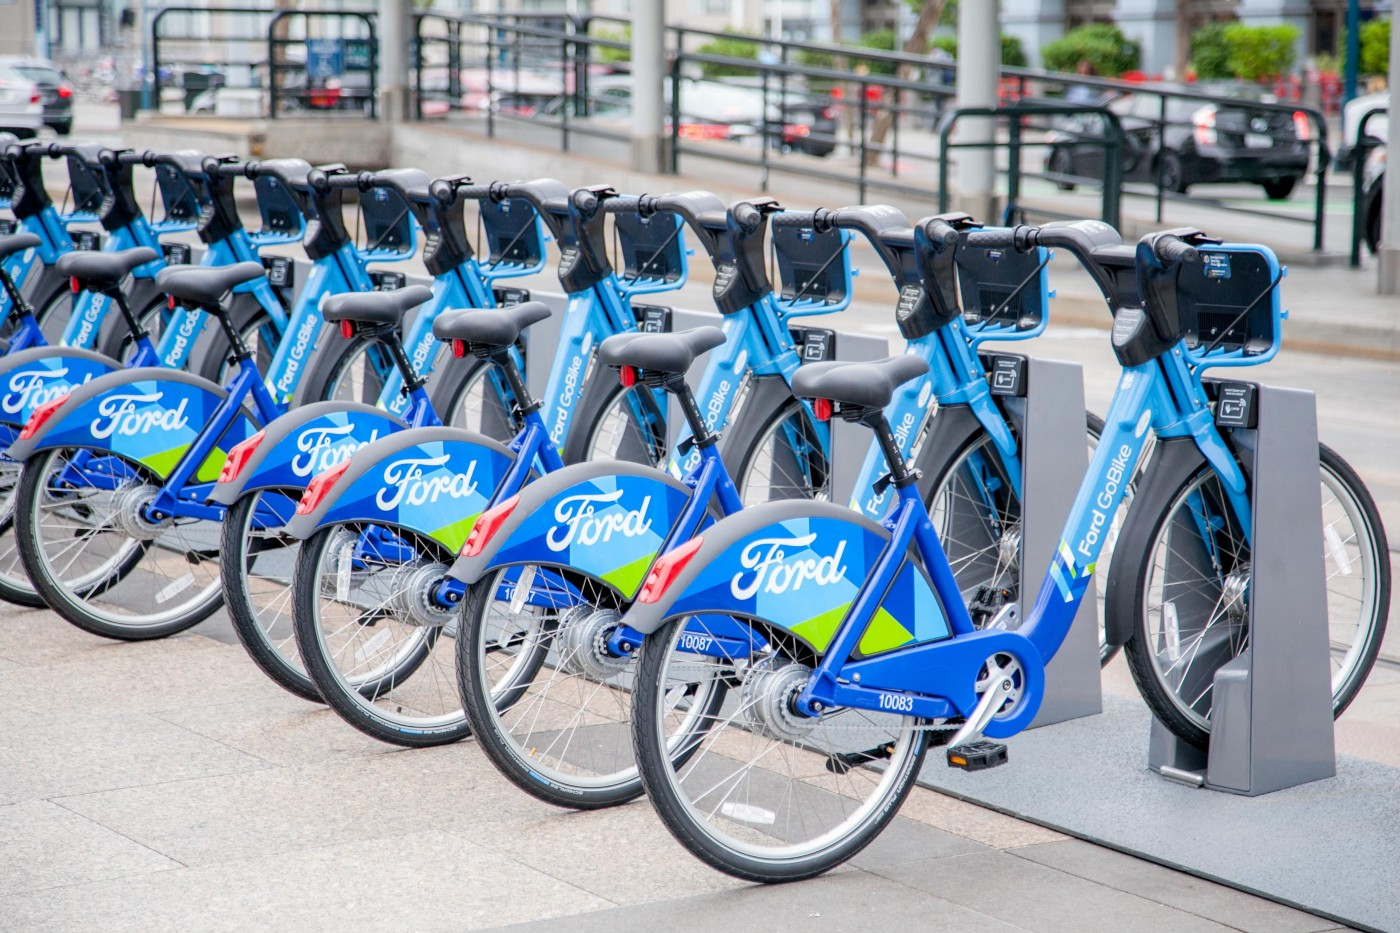

## Table of Contents
- [Introduction](#intro)
- [Data Wrangling](#wrangling)
- [Univariate Exploration](#univariate)
- [Bivariate Exploration](#bivariate)
- [Multivariate Exploration](#multivariate)
- [Conclusions](#conclusion)

## Introduction
<a id='intro'></a>

This dataset contains information about individual trips in a bike share system that covers the greater San Francisco Bay area.

*Note* that this dataset needs some data processing so that it can be cleaned up for analysis. The linked system covers multiple cities, and multiple data files will need to be merged if full year coverage is desired. If you are adventurous, you can try adding analysis from other cities by following the links on [this page](https://github.com/BetaNYC/Bike-Share-Data-Best-Practices/wiki/Bike-Share-Data-Systems).




# Data Wrangling
<a id='wrangling'></a>

In [654]:
# import all packages and set plots to be embedded inline
from requests import get
from zipfile import ZipFile
from io import StringIO, BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as ms
import haversine as hs
%matplotlib inline

> At the beginning of the project, I will load the dataset and then describe its characteristics using the following questions. This will help motivate me to achieve my research goals.

> After that, I will take care of cleaning up any quality or order problems of the dataset before proceeding with the analysis.

In [655]:
#Download the fordgobike dataset from the Udacity provided link
url = 'https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv'
data_csv = get(url)
data_csv
#<Response [200]> = Success

<Response [200]>

In [656]:
#Store the downloaded data in a csv file and verify it
df = pd.read_csv(StringIO(data_csv.content.decode('utf-8')))
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


##### After dealing with the features of interest and visually assessing the data, it becomes clear that additional wrangling is required to archive the intended results. I will do this following the wrangling process:

> * Programmatic evaluation of the data to find quality and order problems.
> * Data Cleaning  according to the Define, Code and Test step.


### Programmatic Evaluation

In [657]:
#Check the size of the data (rows,columns)
df.shape

(183412, 16)

In [658]:
#Explore the column information to see if there are null values and incorrect data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [659]:
#Show the sum of null entries for each column
df.isnull().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

In [660]:
#Verify if the data contains duplicate rows
df.duplicated().sum()

0

In [661]:
# describe the data to generate descriptive statistics
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000


### Data Cleaning 

### Quality Issues
 - Delete Missing values in start_station_name, start_station_id,end_station_id,end_station_name, member_birth_year and member_gender columns
 - start_time and end_time object to datetime64
 - start_station_latitude float64
 - start_station_longitude float64
 - end_station_latitude float64
 - end_station_longitude float64
 - user_type and member_gender object to Categorical Value
 - member_birth_year float64 to int64.
 - start_station_name and end_station_name object to str
 - start_station_id and end_station_id float64 to int64
 - bike_share_for_all_trip object to Categorical Value


### Tidiness Issues
 - Split start_time into three(3) columns `end/start_time(hr)`, `end/start_day` and `end/start_month`. Then drop `end/start_time`
 - Add new column `age` extract from member_birth_year
 - Add new column `trip_km` by calculating the distance between the coordinates.
 

In [662]:
#Make a copy of the dataset
Bike_clean = df.copy()

#### Define: Delete  missing values in: 
> - **start_station_name**
> - **member_birth_year**
> - **member_gender columns**

#### Code

In [663]:
#Remove missing values.
Bike_clean.dropna(subset=['start_station_name','member_birth_year','start_station_id','end_station_id','end_station_name','member_gender'], inplace = True)

#### Test

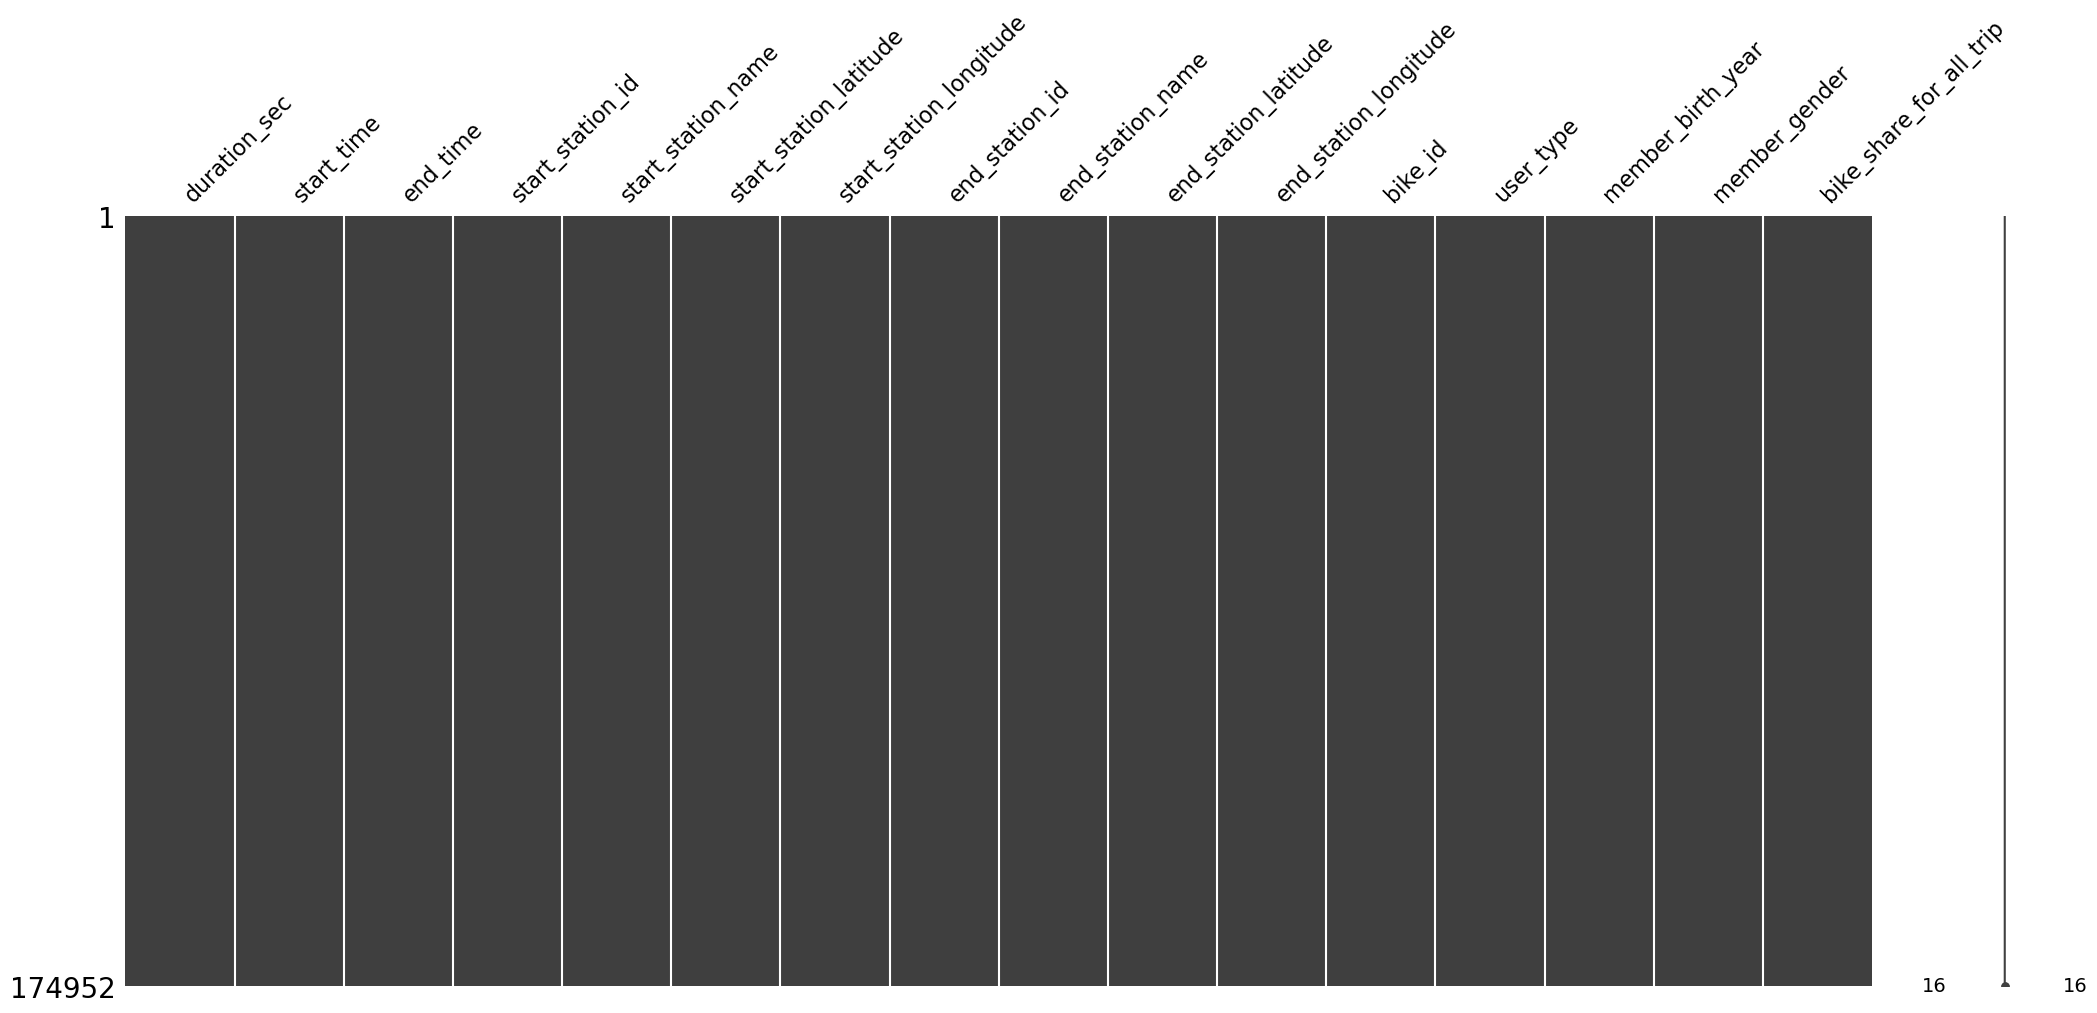

In [664]:
#Verify data cleaning
ms.matrix(Bike_clean);

In [665]:
Bike_clean.isna().sum().sum()

0

#### Define: 
> - **start_time and end_time objects to datetime64**
> - **start_station_latitude float64**
> - **start_station_longitude float64**
> - **end_station_latitude float64**
> - **end_station_longitude float64**
> - **user_type and member_gender to Categorical Value**
> - **member_birth_year float64 to int64.**
> - **start_station_name and end_station_name object to str**
> - **start_station_id and end_station_id float64 to int64**
> - **bike_share_for_all_trip object to Categorical Value**

#### Code

In [666]:
#Converting datatypes
datatype = {'start_time': 'datetime64', 'end_time': 'datetime64','start_station_latitude':'float64','start_station_longitude':'float64',
            'end_station_latitude':'float64','end_station_longitude':'float64','user_type': 'category', 'member_gender': 'category',
            'member_birth_year': 'int','start_station_name':'str','end_station_name':'str','start_station_id':'int','end_station_id':'int',
            'bike_share_for_all_trip':'category'}
Bike_clean = Bike_clean.astype(datatype)

#### Test

In [667]:
print(Bike_clean.shape)
Bike_clean.info()

(174952, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_id         174952 non-null  int32         
 4   start_station_name       174952 non-null  object        
 5   start_station_latitude   174952 non-null  float64       
 6   start_station_longitude  174952 non-null  float64       
 7   end_station_id           174952 non-null  int32         
 8   end_station_name         174952 non-null  object        
 9   end_station_latitude     174952 non-null  float64       
 10  end_station_longitude    174952 non-null  float64       
 11  bike_id                  174952 non-null  int64         
 12  use

### Define: 
> - **Split start_time into three(3) columns start_time(hr), start_day and start_month. Then drop start_time**

#### Code

In [668]:
#Creating new columns for start_time and then drop the column
Bike_clean['start_time(hr)'] = Bike_clean['start_time'].dt.hour
Bike_clean['start_day'] = Bike_clean['start_time'].dt.day_name()
Bike_clean['start_month'] = Bike_clean['start_time'].dt.month_name()

Bike_clean['end_time(hr)'] = Bike_clean['end_time'].dt.hour
Bike_clean['end_day'] = Bike_clean['end_time'].dt.day_name()
Bike_clean['end_month'] = Bike_clean['end_time'].dt.month_name()
# Convert start/end_time to str
Bike_clean['end_time(hr)'] = Bike_clean['end_time(hr)'].astype(str)
Bike_clean['start_time(hr)'] = Bike_clean['start_time(hr)'].astype(str)

# drop start_time/end_time column

Bike_clean.drop('start_time', axis = 1, inplace = True)
Bike_clean.drop('end_time', axis = 1, inplace = True)

#### Test

In [669]:
#show first 5 rows of the dataframe
Bike_clean.head(2)

,duration_sec,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,start_time(hr),start_day,start_month,end_time(hr),end_day,end_month
0,52185,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984,Male,No,17,Thursday,February,8,Friday,March
2,61854,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972,Male,No,12,Thursday,February,5,Friday,March


In [670]:
Bike_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   duration_sec             174952 non-null  int64   
 1   start_station_id         174952 non-null  int32   
 2   start_station_name       174952 non-null  object  
 3   start_station_latitude   174952 non-null  float64 
 4   start_station_longitude  174952 non-null  float64 
 5   end_station_id           174952 non-null  int32   
 6   end_station_name         174952 non-null  object  
 7   end_station_latitude     174952 non-null  float64 
 8   end_station_longitude    174952 non-null  float64 
 9   bike_id                  174952 non-null  int64   
 10  user_type                174952 non-null  category
 11  member_birth_year        174952 non-null  int32   
 12  member_gender            174952 non-null  category
 13  bike_share_for_all_trip  174952 non-null  ca

### Define: Add new column `age` extract from `member_birth_year`

#### Code

In [671]:
#Extract the age from the member's birth year using the year 2019, since the data was collected in 2019
Bike_clean['age'] =  Bike_clean["member_birth_year"].apply(lambda x: 2019 - int(x))
#Bike_clean['age'] = 2019 - Bike_clean.member_birth_year

#### Test

In [672]:
# Show the first 5 Ages
Bike_clean.age.head(), Bike_clean.age.describe()

(0    35
 2    47
 3    30
 4    45
 5    60
 Name: age, dtype: int64,
 count    174952.000000
 mean         34.196865
 std          10.118731
 min          18.000000
 25%          27.000000
 50%          32.000000
 75%          39.000000
 max         141.000000
 Name: age, dtype: float64)

### Define: Add new column `trip_km` by calculating the distance between the coordinates.

#### Code

Part of my exploration is to examine the distance traveled by the trips. Using the latitude and longitude, I can use the geopy library to calculate the distance in kilometers. I used this library to calculate the distance between the coordinates.

https://www.calculator.net/distance-calculator.html
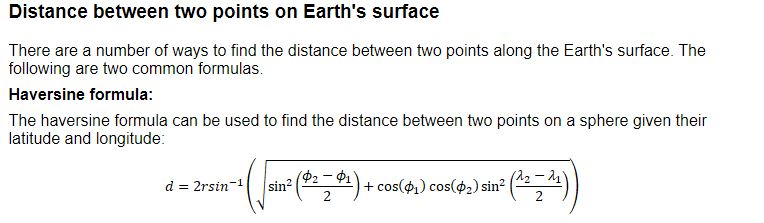

In [673]:
# Cumputing Distance und adding it as a new colum in the Dataset
#https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
Bike_clean['trip_km'] = Bike_clean[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 
                        'end_station_longitude']].apply(lambda x: hs.haversine((x[0],x[1]), (x[2],x[3])), axis=1)

#### Test

In [674]:
Bike_clean.info(),Bike_clean.trip_km

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   duration_sec             174952 non-null  int64   
 1   start_station_id         174952 non-null  int32   
 2   start_station_name       174952 non-null  object  
 3   start_station_latitude   174952 non-null  float64 
 4   start_station_longitude  174952 non-null  float64 
 5   end_station_id           174952 non-null  int32   
 6   end_station_name         174952 non-null  object  
 7   end_station_latitude     174952 non-null  float64 
 8   end_station_longitude    174952 non-null  float64 
 9   bike_id                  174952 non-null  int64   
 10  user_type                174952 non-null  category
 11  member_birth_year        174952 non-null  int32   
 12  member_gender            174952 non-null  category
 13  bike_share_for_all_trip  174952 non-null  ca

(None,
 0         0.544709
 2         2.704549
 3         0.260739
 4         2.409305
 5         3.332207
             ...   
 183407    1.464768
 183408    1.402718
 183409    0.379066
 183410    0.747284
 183411    0.710396
 Name: trip_km, Length: 174952, dtype: float64)

In [675]:
# some Infos about Gender
Bike_clean.member_gender.value_counts() 

Male      130500
Female     40805
Other       3647
Name: member_gender, dtype: int64

In [676]:
# some infos about User_type
Bike_clean.user_type.value_counts()

Subscriber    158386
Customer       16566
Name: user_type, dtype: int64

In [677]:
# On which day of the week did the users ride the Bike?
Bike_clean.start_day.unique(),Bike_clean.start_month.unique()

(array(['Thursday', 'Wednesday', 'Tuesday', 'Monday', 'Sunday', 'Saturday',
        'Friday'], dtype=object),
 array(['February'], dtype=object))

In [678]:
## On which Month did the users ride the Bike?
Bike_clean.start_month.unique(),Bike_clean.end_month.unique()

(array(['February'], dtype=object), array(['March', 'February'], dtype=object))

In [679]:
# 14 Trips end in March
print(Bike_clean[Bike_clean.end_month == "March"].value_counts().sum())
# But all starts in February ---> so all Trips were mad in February
Bike_clean[(Bike_clean.end_month == "March") & (Bike_clean.start_month == "March")].value_counts().sum()

14


0

In [680]:
# Age distribution 
Bike_clean.age.value_counts(), Bike_clean[Bike_clean.age>100].age.value_counts()

(31     10214
 26      9323
 30      8967
 29      8640
 28      8484
        ...  
 91         1
 141        1
 89         1
 109        1
 92         1
 Name: age, Length: 75, dtype: int64,
 119    53
 117    11
 118     6
 141     1
 109     1
 Name: age, dtype: int64)

In [681]:
# some infos about bike_share_for_all_trip
Bike_clean.bike_share_for_all_trip.value_counts()

No     157606
Yes     17346
Name: bike_share_for_all_trip, dtype: int64

### What is the structure of your dataset?


> The dataset contains 183412 rows and 16 columns related to individual trips in the bike sharing system. After cleaning the dataset, I now have 174952 rows and 19 columns, which will be saved as a new data frame named " Bike_clean " ( this is the dataset which I will use for the analysis). However, I extracted the days and hours when the service started and ended into new columns to make it easier to understand. I also created a new column with distance values in kilometers calculated based on the latitude and longitude columns. There are also other characteristics including the duration of the trip in seconds, user type (customers, subscribers), member's year of birth, and gender. The dataset includes entries for the month of February. The resulting dataset consists of more object variables than numeric variables.


### What is/are the main feature(s) of interest in your dataset?

> The most important features are  `start_time`, `duration_sec` and `user_type` , as I want to know when most trips were made in terms of time of day and day of week, how long the average trip lasts and how it affects the user type - `subscriber` or `customer`. Does the duration or distance of a trip depend on whether a user is a `subscriber` or a `customer`? I would also be interested to know if the user type (`subscriber` or `customer`) has an impact on the modality of the service.  

> - **Note that:** After cleaning the dataset, `start_time` now becomes three columns, namely `start_time(hr)`, `start_day` and `start_month`. Then the column `start_time` is deleted (this can be seen in the data frame `Bike_clean`, the data set used for the analysis). Statistics about gender and age may also show the most popular groups that tend to cycle.
### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I will also look at `member_gender`, `trip_km` and `age` (age is extracted from `member_birth_year`) to examine how gender and age affect the main features.


## Univariate Exploration


> Let's have look at some distributions.

In [682]:
# All Trips was made in Februar so no need to the start/end_month
Bike_clean.drop(['start_month','end_month'], axis = 1, inplace = True)

In [683]:
Bike_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   duration_sec             174952 non-null  int64   
 1   start_station_id         174952 non-null  int32   
 2   start_station_name       174952 non-null  object  
 3   start_station_latitude   174952 non-null  float64 
 4   start_station_longitude  174952 non-null  float64 
 5   end_station_id           174952 non-null  int32   
 6   end_station_name         174952 non-null  object  
 7   end_station_latitude     174952 non-null  float64 
 8   end_station_longitude    174952 non-null  float64 
 9   bike_id                  174952 non-null  int64   
 10  user_type                174952 non-null  category
 11  member_birth_year        174952 non-null  int32   
 12  member_gender            174952 non-null  category
 13  bike_share_for_all_trip  174952 non-null  ca

In [684]:
#First transform ordinal objects into the appropriate form
var_dict = {'user_type': ['Subscriber','Customer'],
            'start_day': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            'end_day': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
             'bike_share_for_all_trip': ['No', 'Yes'],
             'start_time(hr)': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
                            '18', '19', '20', '21', '22', '23'],
             'end_time(hr)': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
                            '18', '19', '20', '21', '22', '23']}
for v in var_dict:
    ordered_v = pd.api.types.CategoricalDtype(ordered = True, categories= var_dict[v])
    Bike_clean[v] = Bike_clean[v].astype(ordered_v)

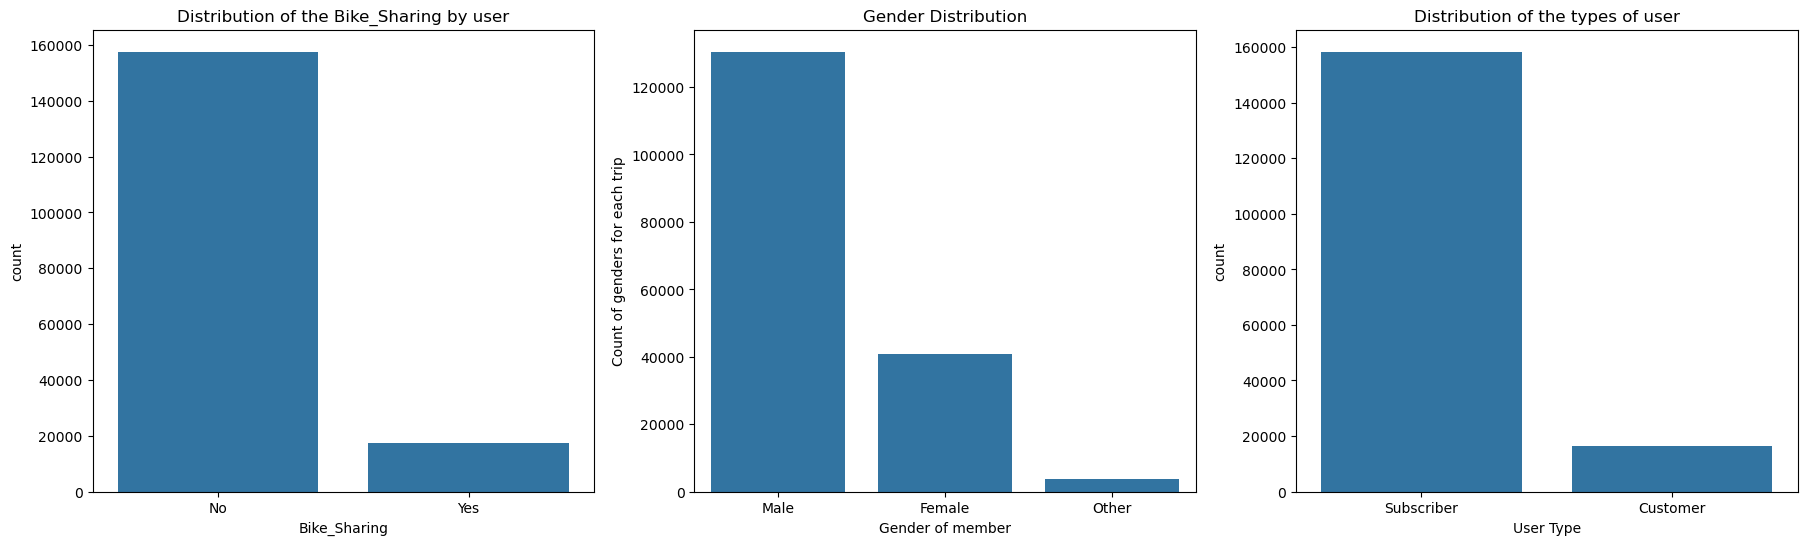

In [685]:
#Uning countplot for categorical data type
# what types of users have made trips?
color = sb.color_palette()[0]
plt.figure(figsize = [22, 6])

plt.subplot(1, 3, 1)
sb.countplot(data = Bike_clean, x = 'bike_share_for_all_trip', color = color);
plt.title('Bike-sharing Distribution');
plt.title("Users By Bike_Sharing");
plt.xlabel("Bike_Sharing");
plt.title('Distribution of the Bike_Sharing by user');

#Distribution of member_gender
plt.subplot(1, 3, 2)
sb.countplot(data = Bike_clean, x = 'member_gender',order = Bike_clean.member_gender.value_counts().index, color = color);
plt.title('Gender Distribution');
plt.xlabel("Gender of member");
plt.ylabel("Count of genders for each trip");

#Distribution of User_type
plt.subplot(1, 3, 3)
sb.countplot(data = Bike_clean, x = 'user_type', color = color);
plt.title("Users By Type");
plt.xlabel("User Type");
plt.title('Distribution of the types of user');

> The graphs show that the bike sharing system has more subscribers than customers and more men than women use the service. Most of the trips are not made with the bike sharing system.

In [686]:
#function to plot a piechart
def pie_Chart(values, labels, title, explode):
    
    explode = explode
    plt.pie(values ,explode=explode,counterclock=False, shadow=False, autopct='%1.1f%%')
    plt.title(title)
    plt.legend(labels, loc='center left', bbox_to_anchor=(1.5, 0.5))
    plt.show()

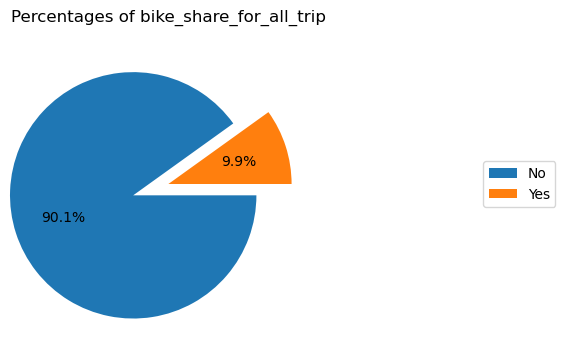

In [687]:
#plot piechart of Most counted Distances in km using function
plt.figure(figsize = [5, 4])
sorted_bike_share_for_all_trip = Bike_clean.bike_share_for_all_trip.value_counts().sort_values(ascending=False)
title = 'Percentages of bike_share_for_all_trip'
explode = (0.3, 0)
pie_Chart(sorted_bike_share_for_all_trip.values, sorted_bike_share_for_all_trip.index, title, explode)

> * Almost 90 % of the trips are made by a Bike share for all Trip

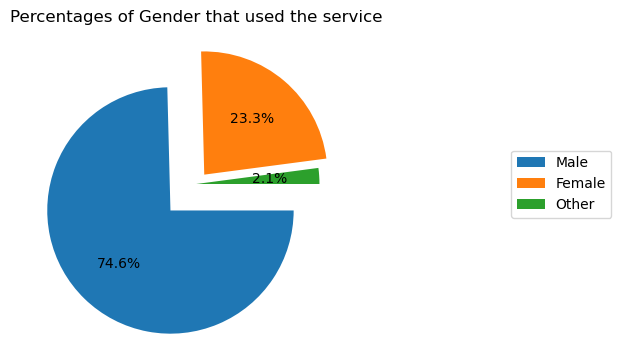

In [688]:
#plot piechart of Distribution of member_gender
plt.figure(figsize = [5, 4])
sorted_gender = Bike_clean.member_gender.value_counts().sort_values(ascending=False)
title = 'Percentages of Gender that used the service'
explode = (0.3, 0.1, 0)
pie_Chart(sorted_gender.values, sorted_gender.index, title, explode)

> * Almost 75% of the trips are made by men, women are just over 20% and others only 2% of rides

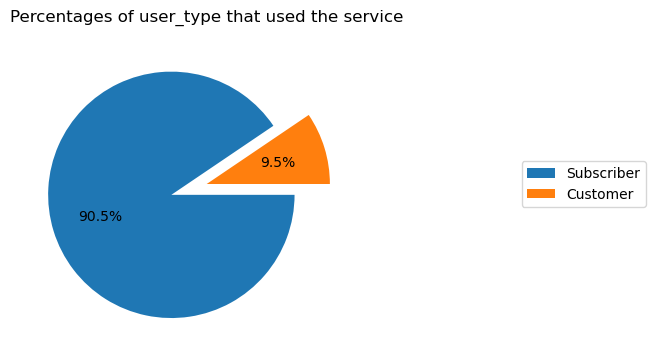

In [689]:
#plot piechart of Most counted Distances in km using function
plt.figure(figsize = [5, 4])
sorted_user_type = Bike_clean.user_type.value_counts().sort_values(ascending=False)
title = 'Percentages of user_type that used the service'
explode = (0.3, 0)
pie_Chart(sorted_user_type.values, sorted_user_type.index, title, explode)

> * From the above chart, there are about 150000+ (Approximately 90 %) Subscribers and the Customers are less than 20000. (Barely 10%)

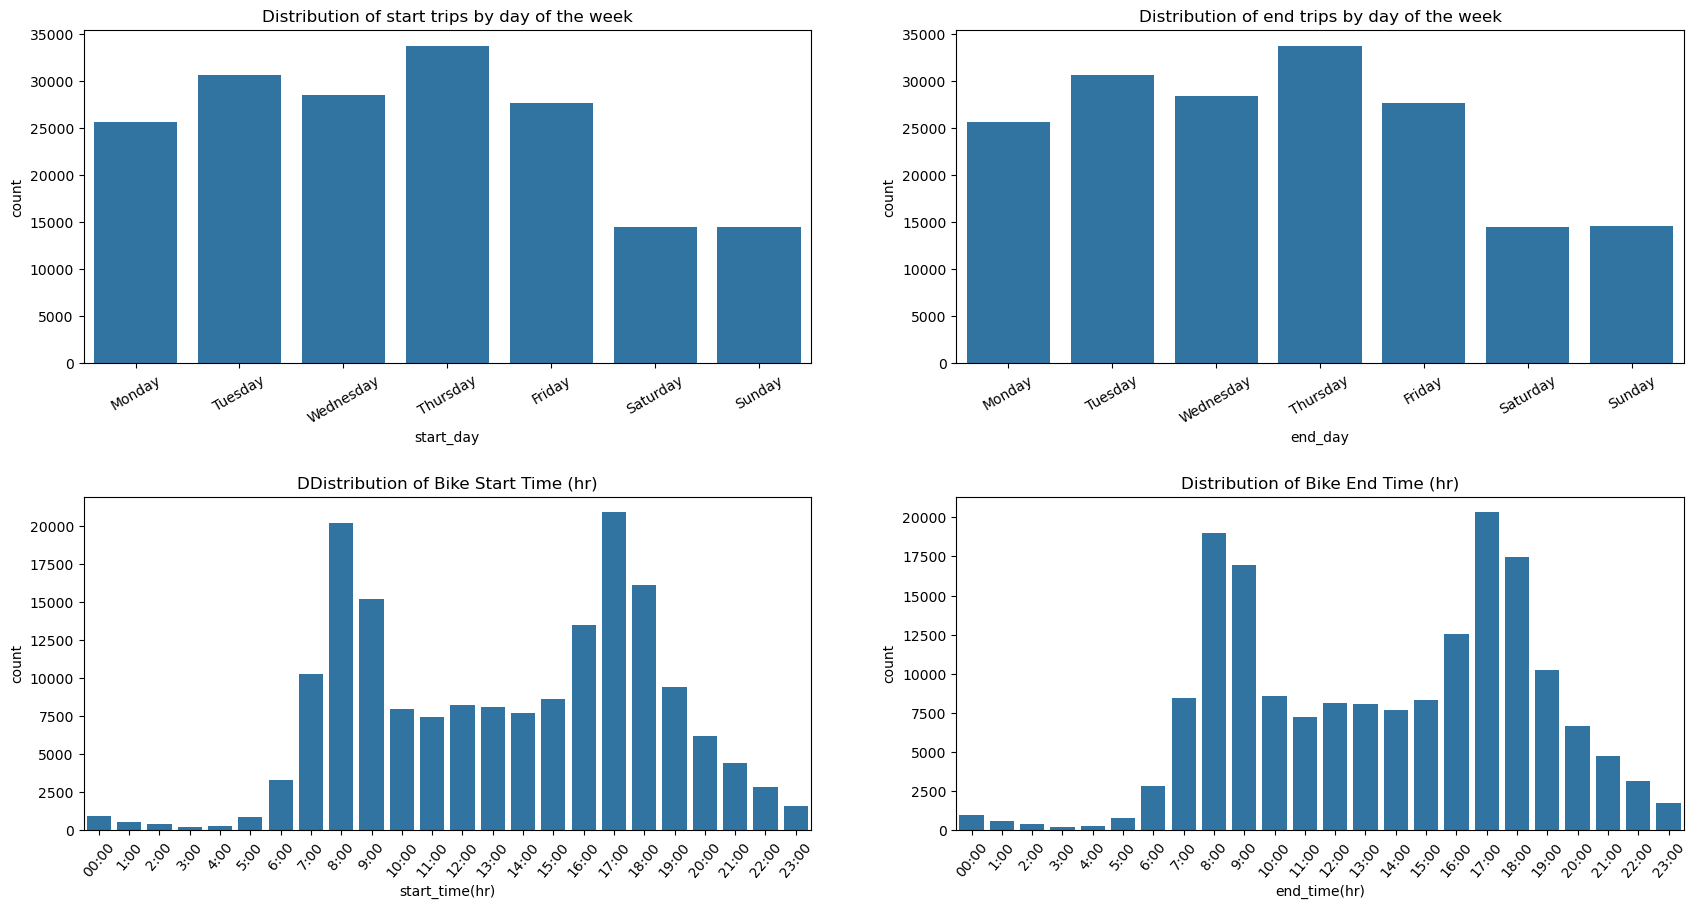

In [690]:
#to plot the three figures side by side
plt.figure(figsize = [20, 10])
color = sb.color_palette()[0]
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

#Distribution of start/end trips by day of the week
plt.subplot(2, 2, 1)
sb.countplot(data = Bike_clean, x ="start_day", color = color);
plt.xticks(rotation = 30)
plt.title('Distribution of start trips by day of the week');

plt.subplot(2, 2, 2)
sb.countplot(data =Bike_clean, x= "end_day", color = color);
plt.xticks(rotation = 30)
plt.title('Distribution of end trips by day of the week');

#Distribution of start/end trips by Hour of the Day
plt.subplot(2, 2, 3)
sb.countplot(data = Bike_clean, x = "start_time(hr)", color = color)
#setting customized ticklabels for x axis
labs = ['00:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00',
       '12:00', '13:00', '14:00', '15:00', '16:00', '17:00','18:00', '19:00', '20:00', '21:00', '22:00', '23:00'] 
plt.xticks(range(24), labs, rotation = 50)
plt.title('DDistribution of Bike Start Time (hr)');

plt.subplot(2, 2, 4)
sb.countplot(data = Bike_clean , x ="end_time(hr)", color = color)
#setting customized ticklabels for x axis
labs = ['00:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00',
       '12:00', '13:00', '14:00', '15:00', '16:00', '17:00','18:00', '19:00', '20:00', '21:00', '22:00', '23:00'] 
plt.xticks(range(24), labs, rotation = 50)
plt.title('Distribution of Bike End Time (hr)');

> From the above graph, we can clearly observe that the trips occurred within a 24-hour time Frame. Both charts for start and end days look the same, with most trips occurring on Thursday, followed by Tuesday, Weekends are also infrequent, with Saturday and Sunday having the lowest number of riders. Also, most trips start at 08.00 AM or 5:00 PM and end at the same time.

**Stations with the most traffic**

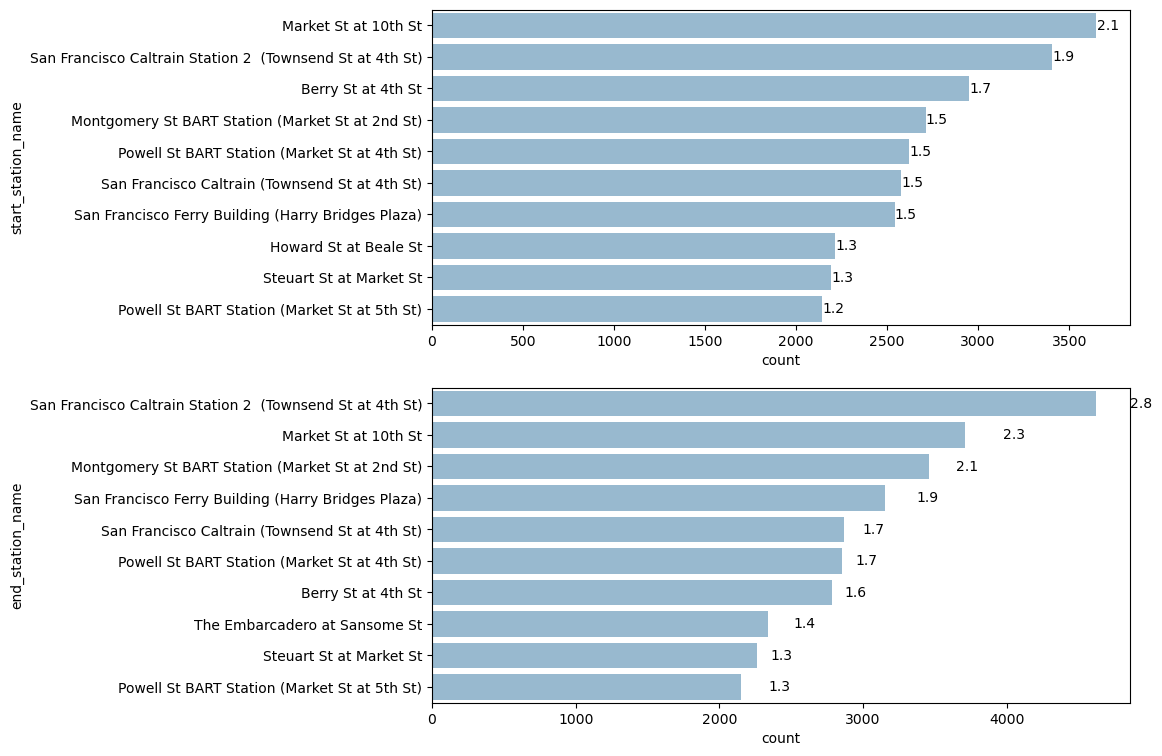

In [691]:
# The  most 10 common Start/End stations for riders
plt.figure(figsize = [9,9])

plt.subplot(2,1, 1)
# Plot the most 10 common start stations for riders on a horizontal bar chart.
type_order = Bike_clean['start_station_name'].value_counts().head(10).index
sb.countplot(data=Bike_clean, y='start_station_name', color=sb.color_palette()[0], order=type_order,alpha = 0.5);

# Add  the Related Value to the bars
type_counts = Bike_clean['start_station_name'].value_counts()
counts = Bike_clean['start_station_name'].value_counts().sum()
for i in range (10):
    count = type_counts[i]
    # Convert count to  a percentage, and then to string
    pct_string = '{:0.1f}'.format(100*count/counts)
    plt.text(count+1, i, pct_string, va='center')

plt.subplot(2,1,2)
# Plot the most 10 common End stations for riders on a horizontal bar chart.
type_order = Bike_clean['end_station_name'].value_counts().head(10).index
sb.countplot(data=Bike_clean, y='end_station_name', color=sb.color_palette()[0], order=type_order,alpha = 0.5);

# Add  the Related Value to the bars
type_counts2 = df['end_station_name'].value_counts()
counts2 = Bike_clean['end_station_name'].value_counts().sum()
for i in range (10):
    count = type_counts2[i]
    # Convert count to  a percentage, and then to string
    pct_string = '{:0.1f}'.format(100*count/counts2)
    plt.text(count+1, i, pct_string, va='center')

In [692]:
# most 20 common used Route
Route = Bike_clean.start_station_name +  ' --> ' + Bike_clean.end_station_name
Route.value_counts().head(20)

Berry St at 4th St --> San Francisco Ferry Building (Harry Bridges Plaza)                   327
Grand Ave at Perkins St --> 19th Street BART Station                                        308
San Francisco Ferry Building (Harry Bridges Plaza) --> The Embarcadero at Sansome St        286
19th Street BART Station --> Grand Ave at Perkins St                                        283
The Embarcadero at Sansome St --> Steuart St at Market St                                   282
Townsend St at 7th St --> San Francisco Caltrain Station 2  (Townsend St at 4th St)         260
San Fernando St at 7th St --> 5th St at Virginia St                                         249
Market St at 10th St --> Montgomery St BART Station (Market St at 2nd St)                   243
5th St at Virginia St --> San Fernando St at 7th St                                         242
Market St at 10th St --> San Francisco Caltrain Station 2  (Townsend St at 4th St)          232
Market St at 10th St --> Powell St BART 

**How is the age of individual users distributed?**

In [693]:
# Some infos about Bike_clean.age
Bike_clean.age.describe(), Bike_clean[Bike_clean.age >= 80].age.value_counts().sum()

(count    174952.000000
 mean         34.196865
 std          10.118731
 min          18.000000
 25%          27.000000
 50%          32.000000
 75%          39.000000
 max         141.000000
 Name: age, dtype: float64,
 203)

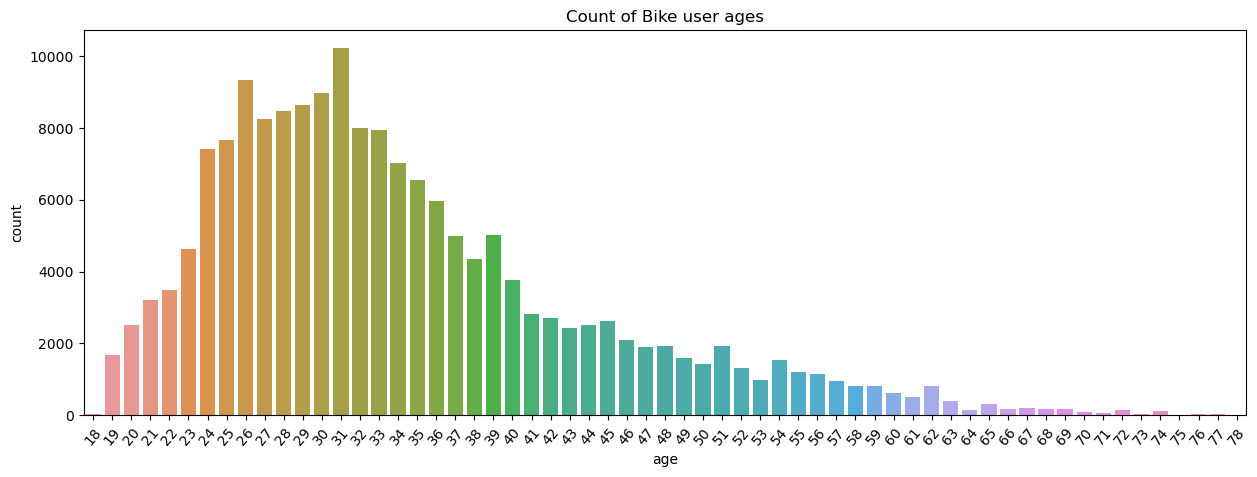

In [694]:
#Overview of the distribution of ages so that an optimal Bins will be chosen 
fig, ax = plt.subplots(figsize = (15,5), dpi = 100)
color = sb.color_palette("cividis_r")
sb.countplot(x = "age", data = Bike_clean.query("age < 80").sort_values("age"));
plt.title("Count of Bike user ages");
plt.xticks(rotation = 50);

In [695]:
#outlier
age_outliers = (Bike_clean['age'] > 80)
#proportion of outliers in Procent %
print((age_outliers.sum()/Bike_clean['age'].sum())*100)

0.0032091943417892265


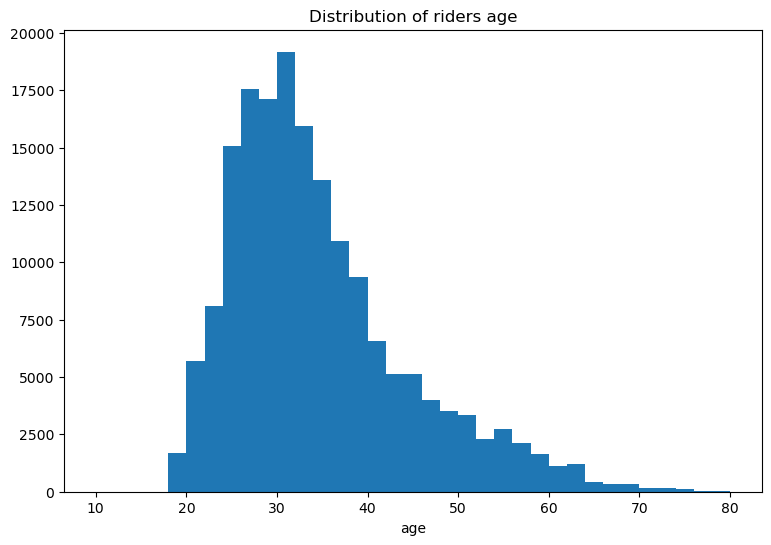

In [696]:
#plot histogram of Distribution of age
binsize = 2
bins = np.arange(10, 80 +binsize, binsize)

plt.figure(figsize=[9, 6])
plt.hist(data = Bike_clean[Bike_clean.age <81], x = 'age', bins = bins)
plt.xlabel('age')
plt.title('Distribution of riders age')
plt.show();

> * The distribution of age has a long tail and skew left. so, let's place this on a logical scale

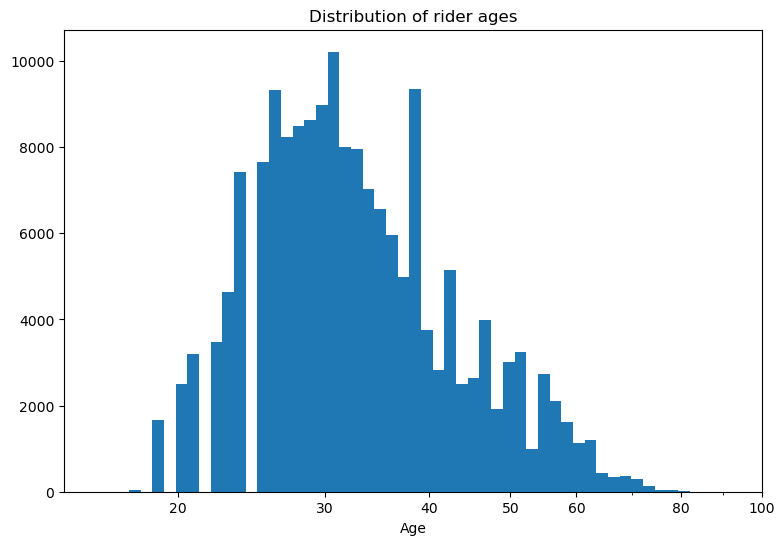

In [697]:
#log scale for age
log_binsize = 0.014
bins = 10 ** np.arange(1.2, np.log10(80)+log_binsize, log_binsize)

plt.figure(figsize=[9, 6])
plt.hist(data = Bike_clean[Bike_clean.age <81], x = 'age', bins = bins)
plt.xscale('log')
plt.xticks([20, 3e1, 4e1, 5e1, 6e1, 8e1, 1e2], [20, '30', '40', '50', '60', '80', '100'])
plt.xlabel('Age')
plt.title('Distribution of rider ages');

* It looks that most drivers are between 25 and 35 years old fter applying a log transformation.
* This analysis does not take repeated users into consideration, as there is no information about the user ID.

**How is the duration of each trip distributed?**

In [698]:
#plotting a distribution of trip duration
Bike_clean['duration_min'] = Bike_clean['duration_sec']/60
# some infos about duration_min
Bike_clean.duration_min.describe()

count    174952.000000
mean         11.733379
std          27.370082
min           1.016667
25%           5.383333
50%           8.500000
75%          13.150000
max        1409.133333
Name: duration_min, dtype: float64

In [699]:
# drop duration_sec cause it was replaced by duration_min
Bike_clean.drop('duration_sec', axis = 1, inplace = True)

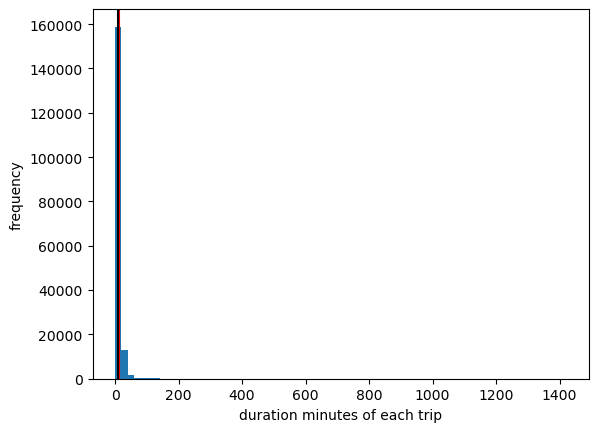

In [700]:
binsize = 20
bins = np.arange(0, Bike_clean.duration_min.max() + binsize , binsize)
plt.hist(Bike_clean['duration_min'],bins = bins)

plt.axvline(np.mean(Bike_clean['duration_min']), color = 'r')
plt.axvline(np.median(Bike_clean['duration_min']), color = 'black')
plt.xlabel('duration minutes of each trip')
plt.ylabel('frequency');

In [701]:
#Outlier 
high_outliers = (Bike_clean['duration_min'] > 67.5)
#proportion of outliers in Procent %
print(high_outliers.sum()/Bike_clean['duration_min'].sum()*100)#proportion of outlier

0.05723950294092507


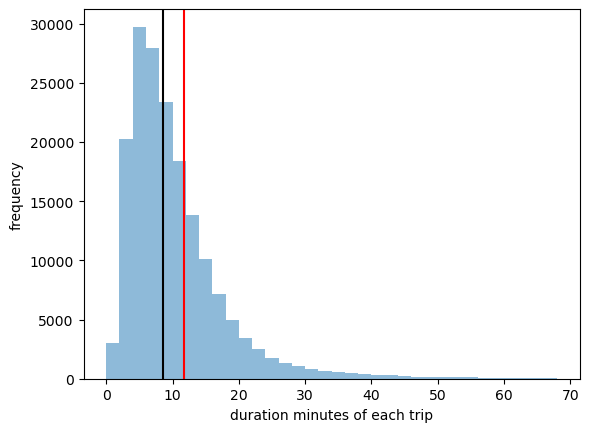

In [702]:
binsize = 2
bins = np.arange(0, 67.5+ binsize, binsize)
plt.hist(Bike_clean['duration_min'],bins = bins,alpha = 0.5)

plt.axvline(np.mean(Bike_clean['duration_min']), color = 'r')
plt.axvline(np.median(Bike_clean['duration_min']), color = 'black')
plt.xlabel('duration minutes of each trip')
plt.ylabel('frequency');

> * The distribution is right skewed., so let's put it on a log scale

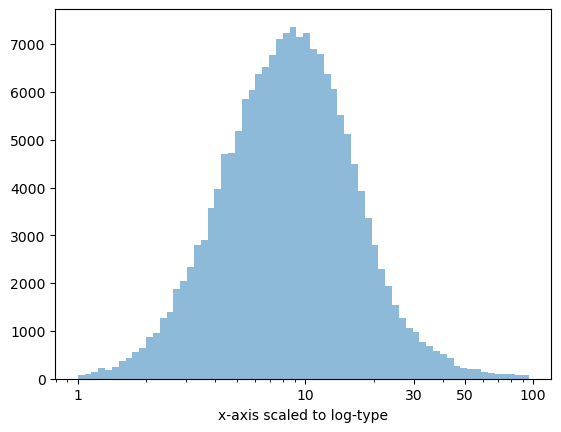

In [703]:
## there's a long tail in the distribution, so let's put it on a log scale
bins = 10 ** np.arange(0, 2, 0.03)
plt.hist(data=Bike_clean, x='duration_min', bins=bins,alpha = 0.5);

plt.xscale('log')# Axis transformation
plt.xticks([1,10,30,50,100], [1,10,30,50,100])
plt.xlabel('x-axis scaled to log-type');

> * The curve has a long tail and is unimodal. When converted to a logarithmic scale, the graph can correspond to a normal distribution, with a peak between 5-20 minutes.

In [704]:
# let's drop the Bike_clean['duration_min'] > 67.5
Bike_clean = Bike_clean.loc[-high_outliers] 

**How is the distance of each trip distributed?**

In [705]:
# Trip-km Distribution
Bike_clean.trip_km.describe()

count    173777.000000
mean          1.690719
std           1.081752
min           0.000000
25%           0.910957
50%           1.429923
75%           2.223916
max          15.673977
Name: trip_km, dtype: float64

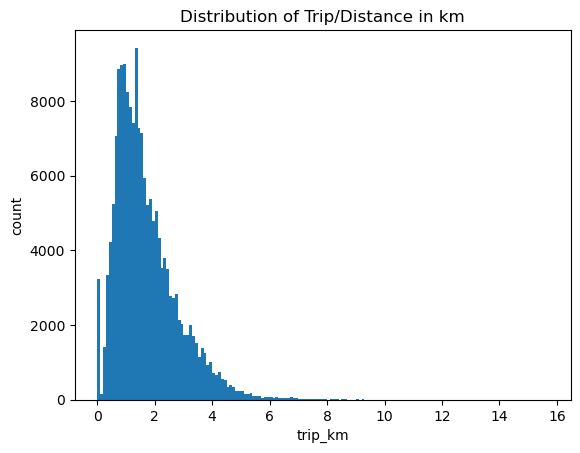

In [706]:
#Visualizing distribution of trip distance covered
binsize = 0.1
bins = np.arange(0, Bike_clean['trip_km'].max()+binsize, binsize)
plt.hist(data = Bike_clean, x = 'trip_km', bins = bins)
plt.xlabel('trip_km')
plt.title('Distribution of Trip/Distance in km')
plt.ylabel('count');

The diagram is not clear, let's take out some values.

In [707]:
#Outlier 
high_outliers = (Bike_clean['trip_km'] >8) | (Bike_clean['trip_km'] == 0)
#proportion of outliers in Procent %
print(high_outliers.sum()/Bike_clean['trip_km'].sum()*100)#proportion of outlier

1.1160345918131038


In [708]:
a = Bike_clean[(Bike_clean['trip_km'] <8) | (Bike_clean['trip_km'] > 0)]
np.mean(Bike_clean[(Bike_clean['trip_km'] <8) | (Bike_clean['trip_km'] > 0)]["trip_km"])

1.6907191248113256

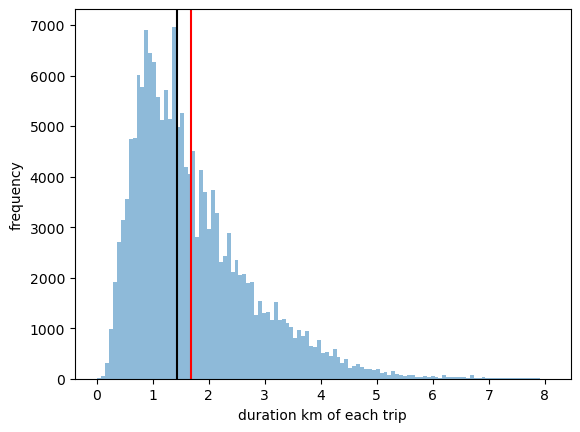

In [709]:
binsize = 0.07
bins = np.arange(0.01, 8+ binsize, binsize)
plt.hist( Bike_clean['trip_km'],bins = bins,alpha = 0.5)

plt.axvline(np.mean(Bike_clean[(Bike_clean['trip_km'] <8) | (Bike_clean['trip_km'] > 0)]['trip_km']), color = 'r')
plt.axvline(np.median(Bike_clean[(Bike_clean['trip_km'] <8) | (Bike_clean['trip_km'] > 0)]['trip_km']), color = 'black')
plt.xlabel('duration km of each trip')
plt.ylabel('frequency');

> * From the diagram above, we can see that most of the trips are between 0.5 and 1.5 km. whereby i did not consider the 0km trips and the trips greater than 8km, so our graph is clearer.  

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Univariate testing was done to see how each variable was distributed. I expected that user type, duration, distance, and start time would support my investigation. Therefore, I looked at each variable on its own. Since the variables to be examined were ordered categories, i.e., user type and days of the week extracted, I ordered them appropriately and then used the sb.countplot() function to plot the distribution.

> The distribution showed that the trips occurred within a 24-hour time frame. The graphs for the starting and ending days appeared the same and unimodal, showing that most trips occurred on Thursday, followed by Tuesday. Weekends are also infrequent, since Saturday and Sunday have the lowest number of riders. The time-of-day or hourly curve is nearly bimodal, with most trips beginning at 8:00 AM and 5:00 PM. However, this is not so surprising since 8:00 a.m. - 5:00 p.m. fall within the time when most jobs begin and end.


> Also, there are 9 times more subscribers than customers in the dataset.

> Over 70 % of Users are male.

> The most common age groups are between 23 and 28 and between 30 and 35 years old.

> In the `duration_min` column, there are outliers where a trip takes longer than 67.5 minutes, less than 0.05% of the Users. I therefore drop these outliers. 

> The most of the trips are between 0.5 and 1.5 km. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I had to transform the `user_type` column to order it from *Customer* to *Subscriber* since it is an ordinal category. 

> `duration_min` and `Age` columns: The original plots are right skewed and have a long tail. After applying the log transformation, the plot can correspond to a normal distribution.


## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

**Duration based on different time slots ( day of the week, time of day)**

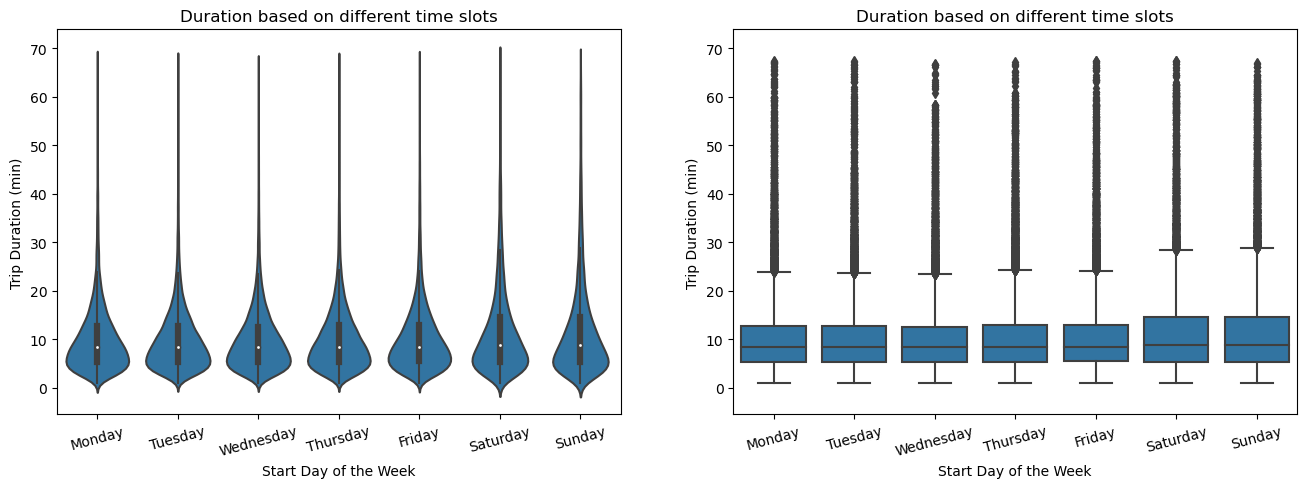

In [710]:
plt.figure(figsize = [16, 5])

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# violin plot
plt.subplot(1, 2, 1)
ax1 = sb.violinplot(data= Bike_clean, x='start_day', y='duration_min', color=sb.color_palette()[0])
plt.xlabel('Start Day of the Week');
plt.ylabel('Trip Duration (min)');
plt.title("Duration based on different time slots");
plt.xticks(rotation=15);

# box plot
plt.subplot(1, 2, 2)
sb.boxplot(data=Bike_clean, x='start_day', y='duration_min', color=sb.color_palette()[0],order = day_order)
plt.xlabel('Start Day of the Week');
plt.ylabel('Trip Duration (min)');
plt.title("Duration based on different time slots");
plt.xticks(rotation=15)
plt.ylim(ax1.get_ylim()); 

In [711]:
Bike_clean['start_time(hr)'] = Bike_clean['start_time(hr)'].astype(int)

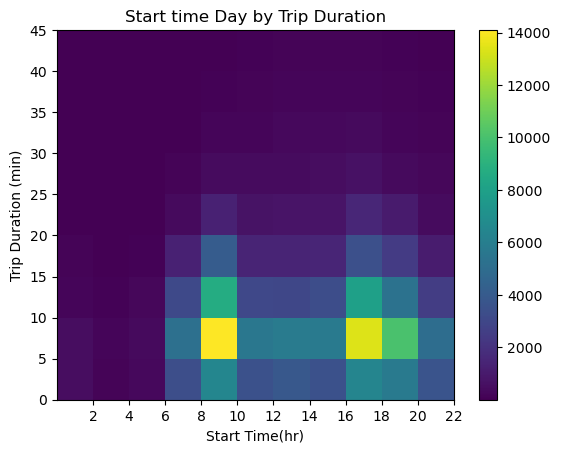

In [712]:
bins_x = np.arange(0,24,2)
bins_y = np.arange(0,50,5)
plt.hist2d(data=Bike_clean, x = 'start_time(hr)', y = 'duration_min',cmin=0.5, bins = [bins_x, bins_y])
plt.colorbar()
plt.xlabel('Start Time(hr)')
plt.ylabel('Trip Duration (min)');
plt.title("Start time Day by Trip Duration");
plt.xticks(np.arange(2, 24, 2));

> * There are two peaks in the heatmap start time duration, one between 8-10am and the other between 4-6pm. The duration of the two peaks is 5-10 minutes. This implies that most users use bike-sharing for commute trips with a duration of 5-10 minutes.
> * On weekends, the trips are longer than on weekdays.

**Implications of user behavior by different types of users.**
* User Type vs. Duration
* User Type vs. Sharing
* User Type vs. Day of Week

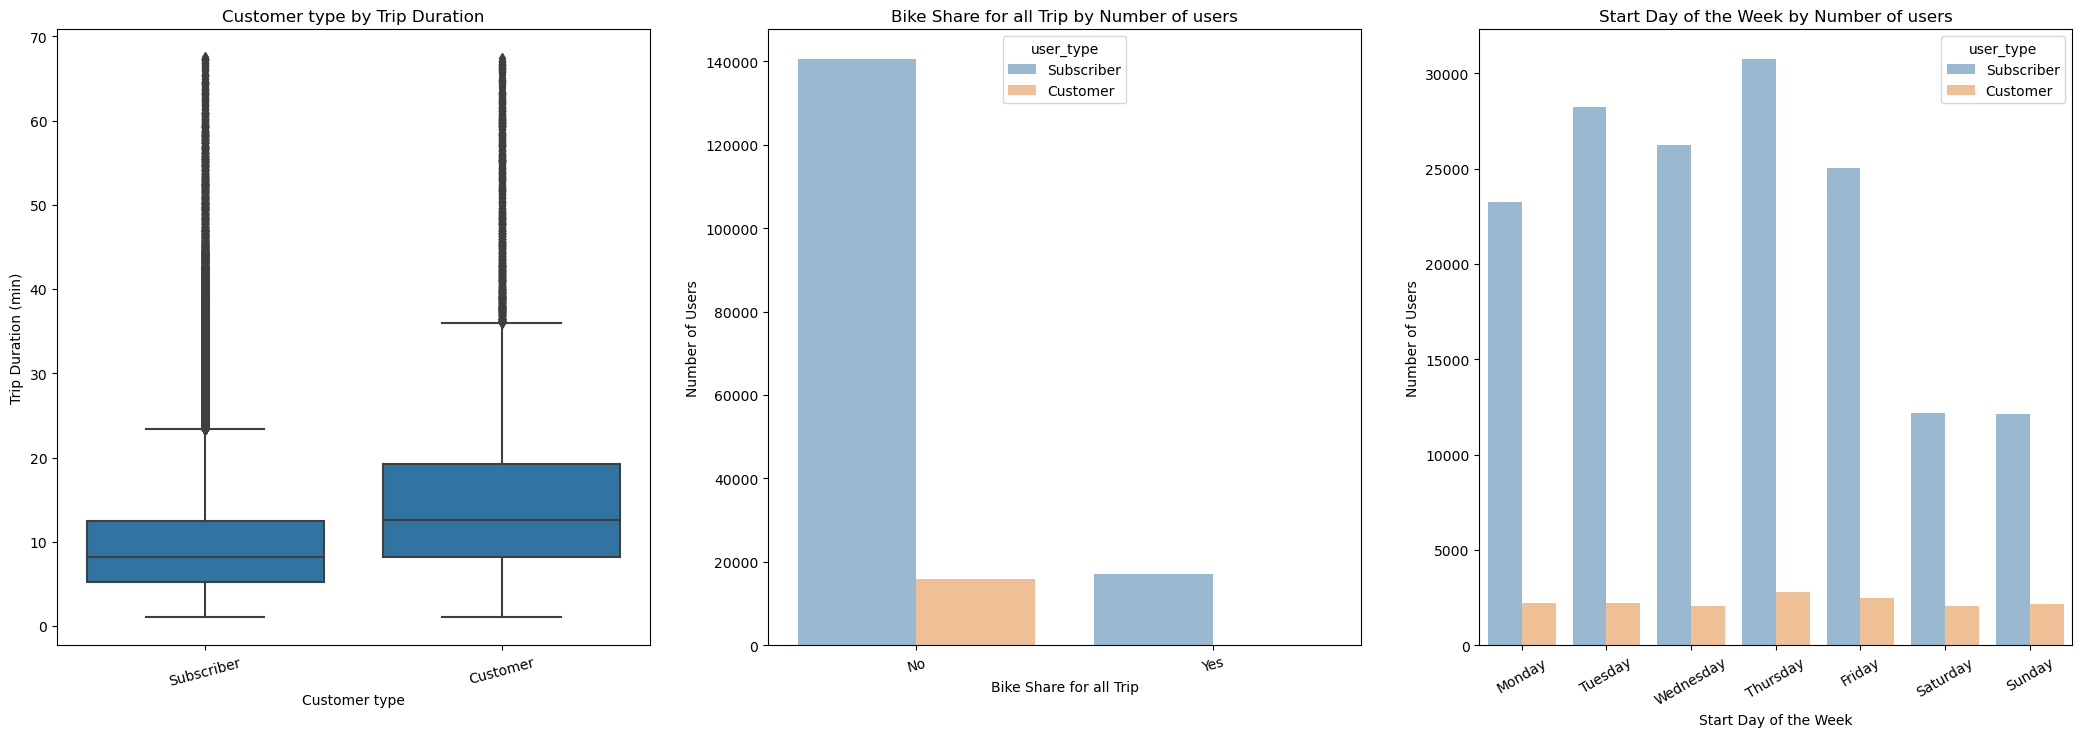

In [713]:
plt.figure(figsize = [26,8])

plt.subplot(1,3, 1)
sb.boxplot(data=Bike_clean, x='user_type', y='duration_min', color=sb.color_palette()[0])
plt.xlabel("Customer type");
plt.ylabel('Trip Duration (min)');
plt.title("Customer type by Trip Duration");
plt.xticks(rotation=15)

plt.subplot(1,3, 2)
sb.countplot(data = Bike_clean, x = 'bike_share_for_all_trip', hue = 'user_type',alpha = 0.5);
plt.xlabel('Bike Share for all Trip');
plt.ylabel('Number of Users');
plt.title("Bike Share for all Trip by Number of users");
plt.xticks(rotation=15)

plt.subplot(1,3, 3)
sb.countplot(data = Bike_clean ,x = 'start_day', hue = 'user_type',alpha = 0.5,order = day_order)
plt.xlabel('Start Day of the Week');
plt.ylabel('Number of Users');
plt.title("Start Day of the Week by Number of users");
plt.xticks(rotation=30);

> * User type vs. duration: Subscribers on average have a shorter trips, but more outliers.
> * User type vs. sharing: Bike sharing only available for subscribers.

> * User Type vs. Day of Week: On weekdays, user type does not affect goBike's daily traffic. On weekends, the daily frequency of customers barely changes, while that of subscribers decreases sharply.

**Implications of user behavior by different Ages of users.**

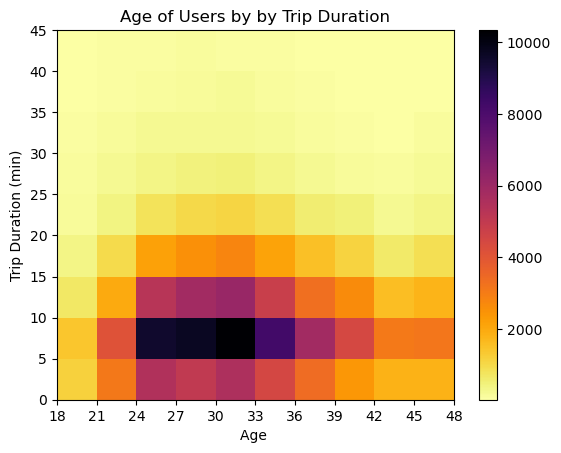

In [714]:
bins_x = np.arange(18,50,3)
bins_y = np.arange(0,50,5)
plt.hist2d(data = Bike_clean, x = 'age', y = 'duration_min',cmin=0.5,bins = [bins_x, bins_y], cmap='inferno_r')
plt.colorbar()
plt.xlabel('Age ');
plt.ylabel('Trip Duration (min)');
plt.title("Age of Users by by Trip Duration");
plt.xticks(np.arange(18,50,3));

> * The 24 to 33 year-old Users are the main group of users. They spend mostly 5-10 minutes on the road. And this is the only peak value of the heatmap.

**Impact on user type according to different user age groups**

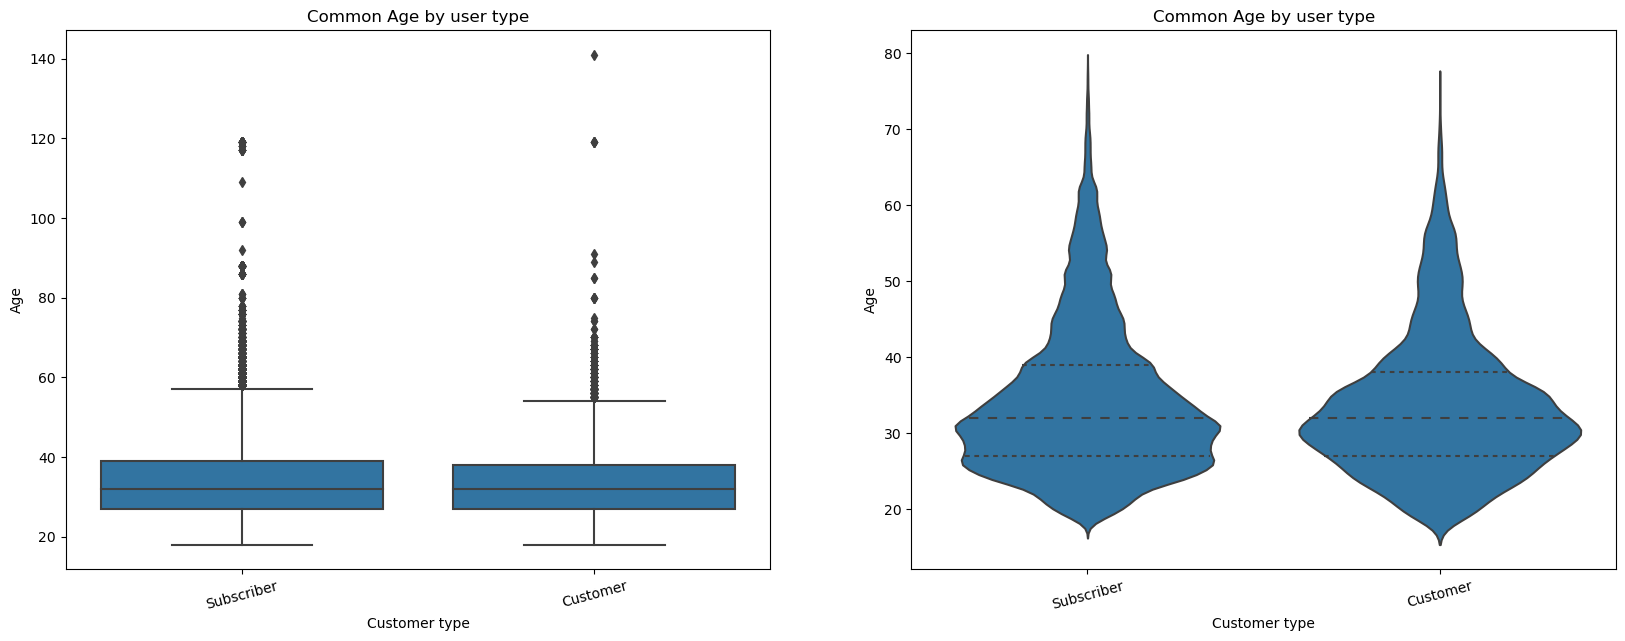

In [715]:
# show user type vs Age in boxplot
plt.figure(figsize = [20,7])
plt.subplot(1,2, 1)
sb.boxplot(data=Bike_clean, x='user_type', y='age', color=sb.color_palette()[0])
plt.xlabel("Customer type");
plt.ylabel("Age");
plt.title("Common Age by user type");
plt.xticks(rotation=15);


#show user type vs Age in violin plot
plt.subplot(1,2, 2)
sb.violinplot(data = Bike_clean.query("age <= 79"),
               x = 'user_type',y='age',
               color = sb.color_palette()[0],inner='quartile');

plt.xlabel("Customer type");
plt.ylabel("Age");
plt.title("Common Age by user type");
plt.xticks(rotation=15);

> * No particular relationship

**Impact on gender by duration and distance**

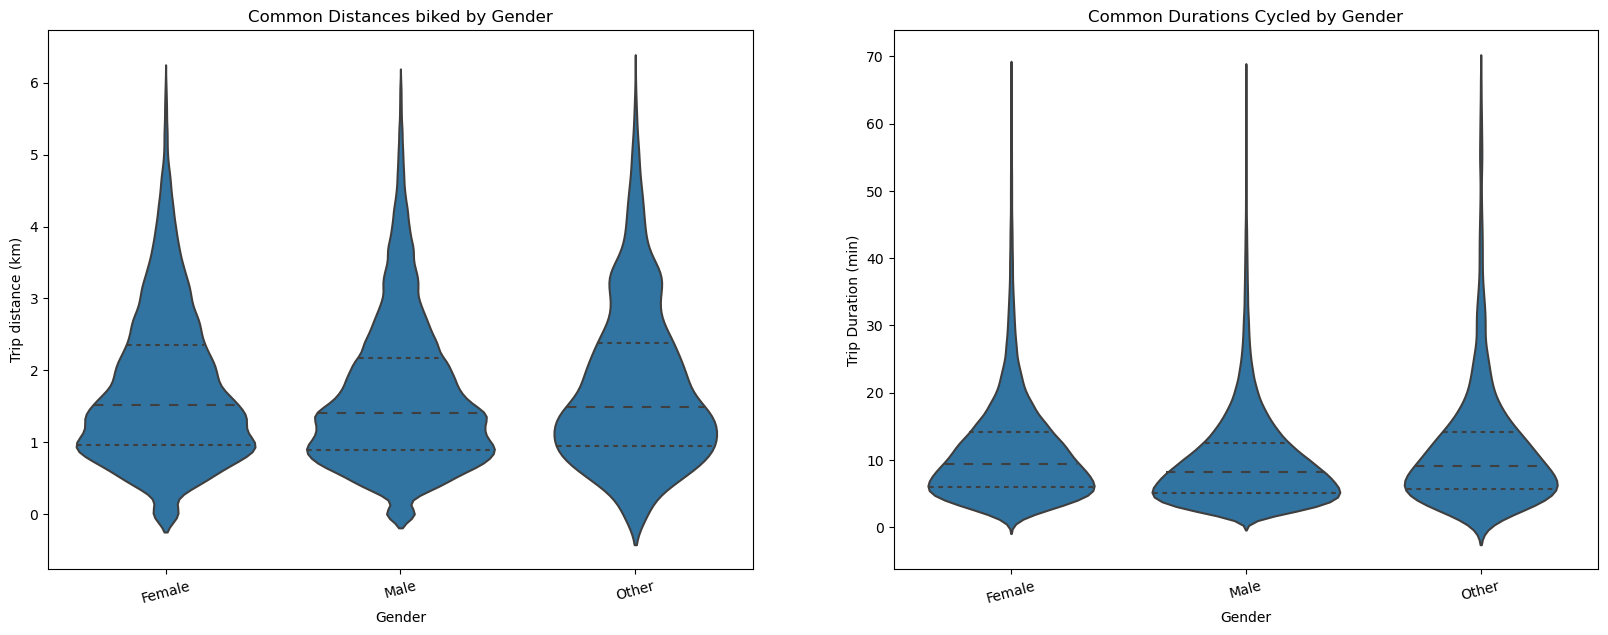

In [716]:
plt.figure(figsize = [20,7])
plt.subplot(1,2, 1)
#show gender count vs distances in violin plot
sb.violinplot(data = Bike_clean.query("trip_km <= 6"),
               x = 'member_gender',y='trip_km',
               color = sb.color_palette()[0],inner='quartile');
plt.xticks(rotation=15);
plt.title("Common Distances biked by Gender");
plt.xlabel("Gender");
plt.ylabel("Trip distance (km)");

#show gender count vs Duration in violin plot
plt.subplot(1,2, 2)
sb.violinplot(data = Bike_clean,
               x = 'member_gender',y='duration_min',
               color = sb.color_palette()[0],inner='quartile');
plt.xticks(rotation=15);
plt.title("Common Durations Cycled by Gender");
plt.xlabel("Gender");
plt.ylabel("Trip Duration (min)");

>  * There are no large differences between genders regarding the duration of trips and the distance cycled.

**Impact on user type by duration and distance**

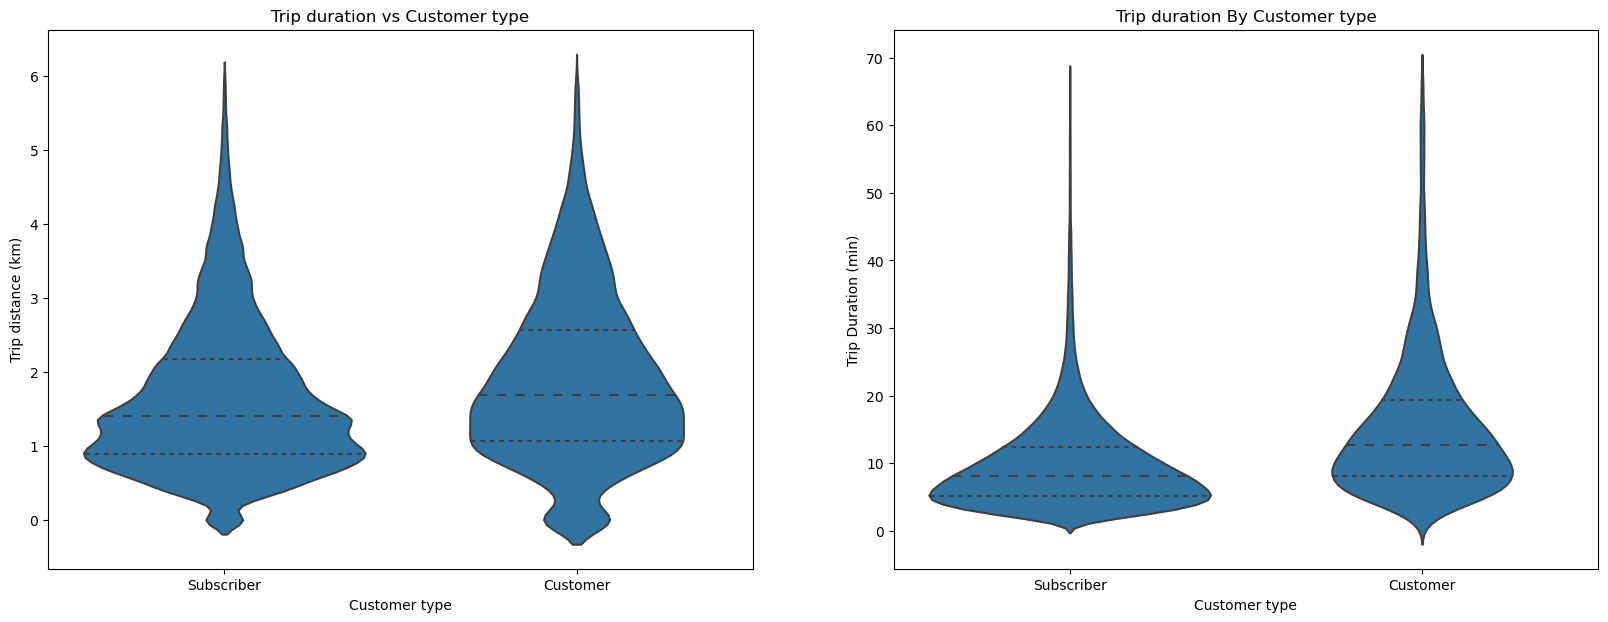

In [717]:
plt.figure(figsize = [20,7])
plt.subplot(1,2, 1)
sb.violinplot(data = Bike_clean.query("trip_km <= 6"),x = 'user_type',y='trip_km',color = sb.color_palette()[0],inner='quartile');
plt.title("Trip duration vs Customer type");
plt.xlabel("Customer type");
plt.ylabel("Trip distance (km)");

plt.subplot(1,2, 2)
#show user type vs duration in violin plot
sb.violinplot(data = Bike_clean,
               x = 'user_type',y='duration_min',
               color = sb.color_palette()[0],inner='quartile');
plt.title("Trip duration By Customer type");
plt.xlabel("Customer type");
plt.ylabel("Trip Duration (min)");

> * Customers are more likely to ride longer distances for a longer duration, while subscribers are more likely to ride shorter distances.

**Impact on the Age according to the duration of the trip**

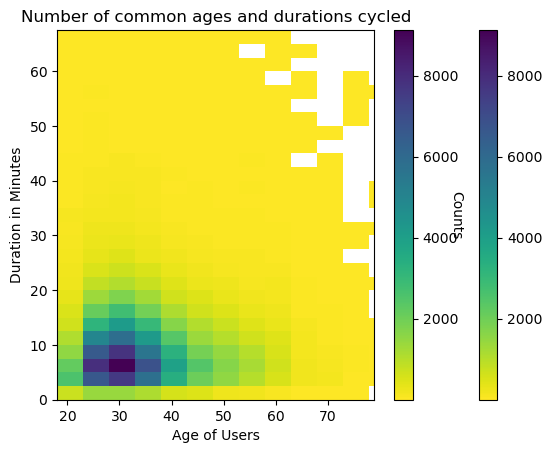

In [718]:
#plot 2d histogram to show count of births vs duration cycled
xbin = np.arange(Bike_clean['age'].min(), Bike_clean['age'].max()+5, 5)
ybin = np.arange(0, 68, 2.5)
plt.hist2d(data = Bike_clean,x = 'age',y='duration_min',cmin=0.5,cmap = 'viridis_r',bins=[xbin, ybin]);
plt.xlim(18, 79);
plt.colorbar();
plt.colorbar().set_label('Counts', rotation=270);
plt.title("Number of common ages and durations cycled");
plt.xlabel("Age of Users");
plt.ylabel("Duration in Minutes");

> * Users with ages between 23 and 33 are the most common and cycle for the longest duration.

**Location Heat Map**

In [719]:
Bike_clean.reset_index(inplace = True)

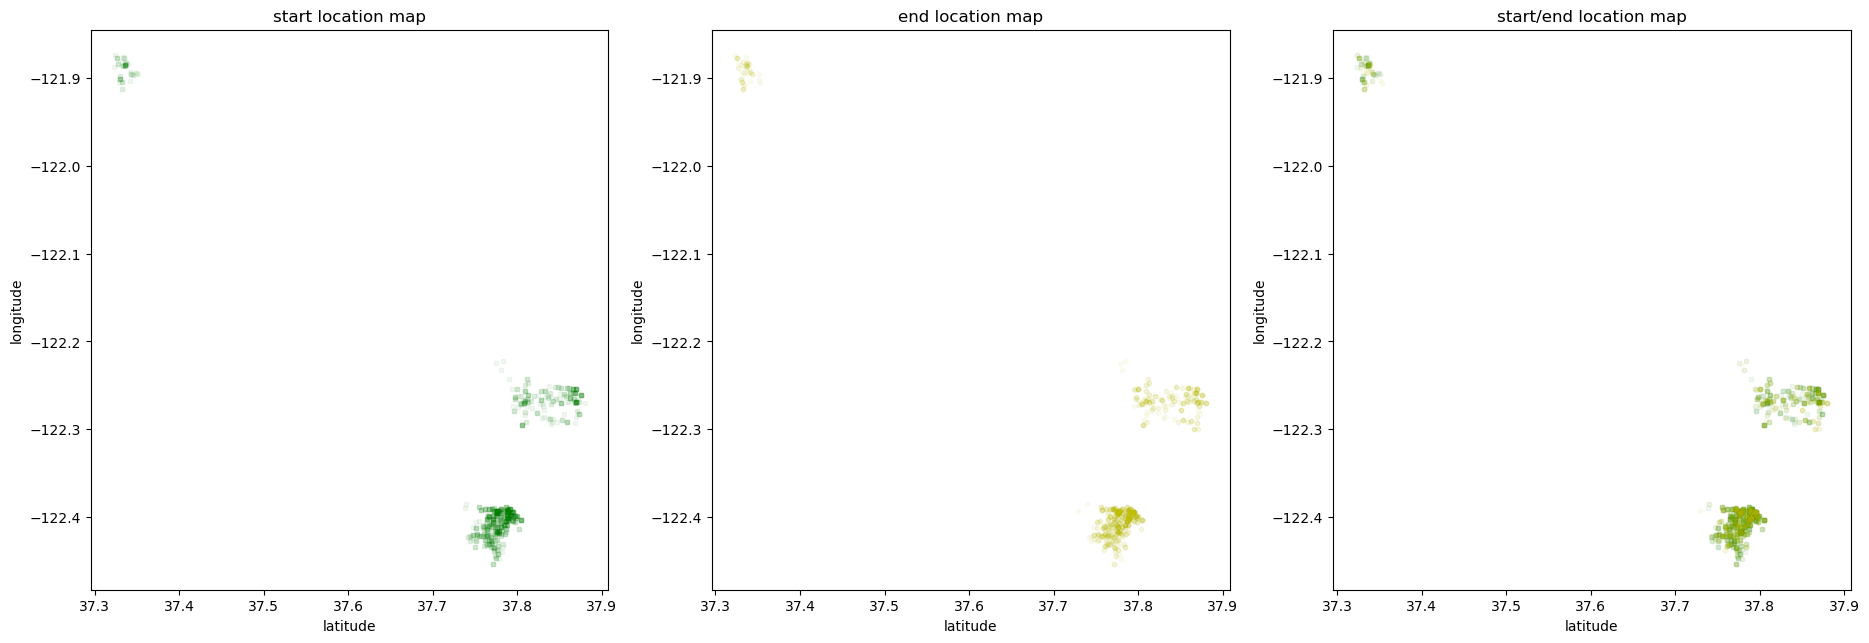

In [720]:
samples = np.random.choice(Bike_clean.shape[0], 1000, replace = False)
Bike_cam = Bike_clean.loc[samples,:]



plt.figure(figsize = [22,7])
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)


plt.subplot(1,3, 1)
plt.scatter(Bike_cam['start_station_latitude'], Bike_cam['start_station_longitude'], label='start',alpha = 0.05 ,s=10, c='g', marker="s")
plt.ylabel('longitude')
plt.xlabel('latitude')
plt.title('start location map')

plt.subplot(1,3, 2)
plt.scatter(Bike_cam['end_station_latitude'],Bike_cam['end_station_longitude'], label='end',alpha = 0.05, s=10, c='y', marker="o")
plt.ylabel('longitude')
plt.xlabel('latitude')
plt.title('end location map')

plt.subplot(1,3, 3)
plt.scatter(Bike_cam['start_station_latitude'], Bike_cam['start_station_longitude'], label='start',alpha = 0.05, s=10, c='g', marker="s")
plt.scatter(Bike_cam['end_station_latitude'],Bike_cam['end_station_longitude'], label='end',alpha = 0.05, s=10, c='y', marker="o")
plt.ylabel('longitude')
plt.xlabel('latitude')
plt.title('start/end location map')


plt.show()


> * The scatter map displays the 3 areas with the highest traffic volume.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

>  * The user type can influence the duration and frequency of each trip. Subscribers usually ride on weekdays, most frequently  between 8-10am and between 4-6pm, where each ride usually takes 5-10 minutes. Since 90% of users are subscribers, we can infer that they have subscribed for the purpose of commuting. And the day of the week does not influence the frequency of regular users. So we can conclude that they use the service for a random purpose.
>  * On weekends, the trips are longer than on weekdays.
>  * The 24 to 33 year-old Users are the main group of users. They spend mostly 5-10 minutes on the road, cycling the longest duration. And this is the only peak value of the heatmap.
>  * Customers are more likely to ride longer distances for a the longer duration , while subscribers are more likely to ride shorter distances.
>  * There are no large differences between genders regarding the duration of trips and the distance cycled.



### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> * I found the data to be very balanced. The most frequent users are between 23 and 33 years old and cycled the farthest.
> * Using the scatter plots for latitude and longitude, we can identify 3 main areas of start and end stations.

## Multivariate Exploration

**Duration vs. day of the week of different user types**

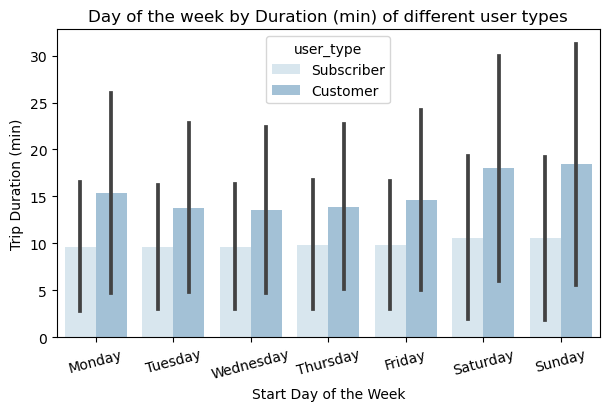

In [721]:
plt.figure(figsize = [7,4])
sb.barplot(data=Bike_clean, x='start_day', y='duration_min',hue = 'user_type', palette = 'Blues', ci='sd',alpha = 0.5)
plt.xticks(rotation=15);
plt.xlabel('Start Day of the Week');
plt.ylabel('Trip Duration (min)');
plt.title("Day of the week by Duration (min) of different user types");

> * Subscriber usage time during the week does not change much on average.
> * On weekends, subscriber usage time is higher.

**Average distance/Trip Duration cycled by gender and different types of users**

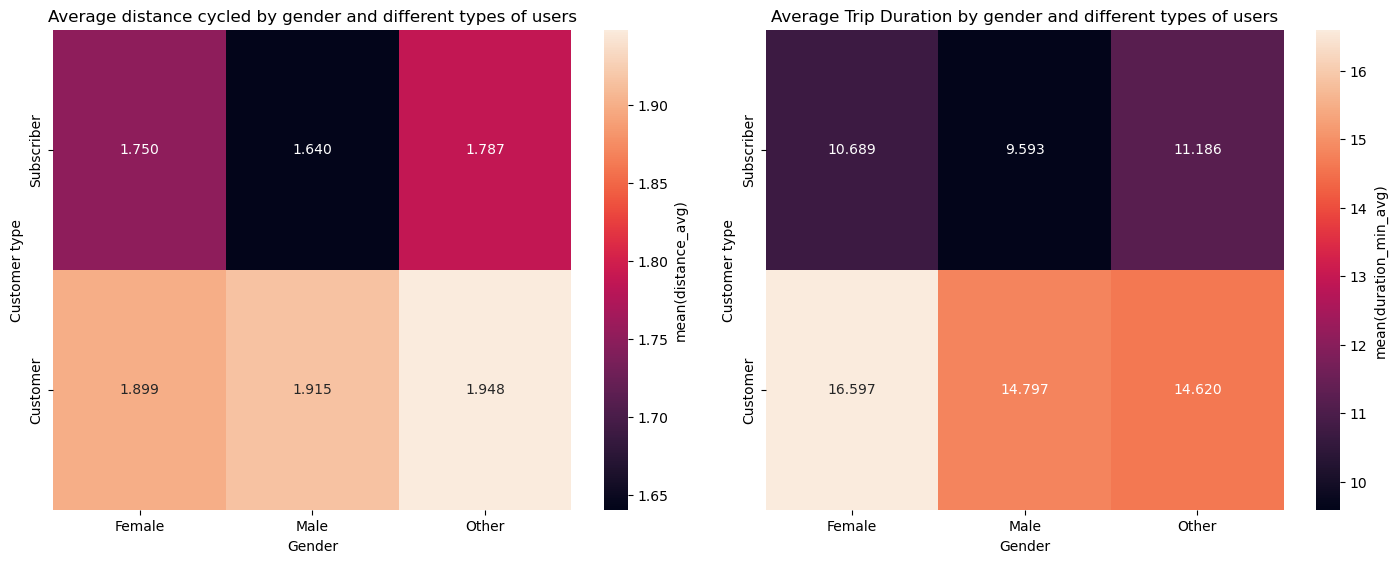

In [723]:
plt.figure(figsize=[17,6])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)


plt.subplot(1,2, 1)
#plot heatmap with seaborn Average distance cycled by gender and different types of users
cat_means = Bike_clean.groupby(['member_gender', 'user_type']).mean()['trip_km']
cat_means = cat_means.reset_index(name = 'distance_avg')
cat_means = cat_means.pivot(index = 'user_type', columns = 'member_gender',
                            values = 'distance_avg')
sb.heatmap(cat_means, annot = True, fmt = '.3f',
           #set heat map to distance_avg mean
           cbar_kws = {'label' : 'mean(distance_avg)'});
plt.xlabel('Gender');
plt.ylabel("Customer type");
plt.title("Average distance cycled by gender and different types of users");


plt.subplot(1,2, 2)
#plot heatmap with seaborn Average Trip Duration cycled by gender and different types of users
cat_means = Bike_clean.groupby(['member_gender', 'user_type']).mean()['duration_min']
cat_means = cat_means.reset_index(name = 'duration_min_avg')
cat_means = cat_means.pivot(index = 'user_type', columns = 'member_gender',
                            values = 'duration_min_avg')
plt.title("Count of user type, gender Average distance mean");
sb.heatmap(cat_means, annot = True, fmt = '.3f',
           #set heat map to duration_avg mean
           cbar_kws = {'label' : 'mean(duration_min_avg)'});
plt.xlabel('Gender');
plt.ylabel("Customer type");
plt.title("Average Trip Duration by gender and different types of users");

> * Customers cycled on average 1.5 times the duration of subscribers. The gender "Other" cycled the longest, which means that either men or women did not specify their gender or that there were outliers in the data.
> * Average distances did not differ much between customers and subscribers, implying that there may have been long periods of time when cycling did not occur, as longer cycling time should be associated with greater distance traveled.


**Gender vs cycled distance of different age groups**

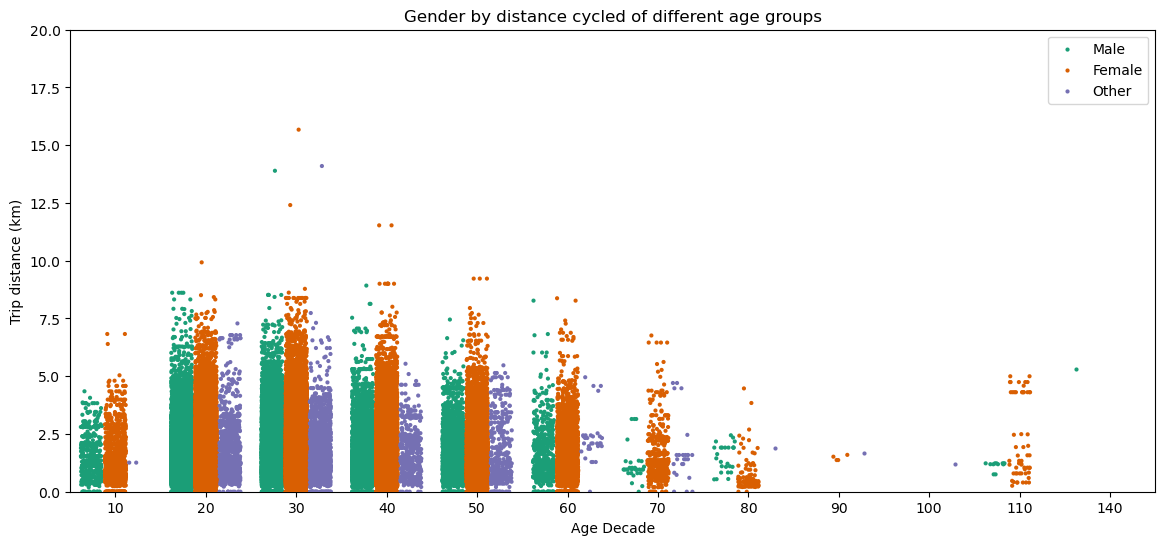

In [724]:
#Define plot dimensions
plt.figure(figsize=[14,6])

#Building a decade variable, using floor division (lowest integer divisor)
Bike_clean['age_decade'] = ((Bike_clean['age']//10)*10).astype(int)
                                                                     
#use decade
sb.stripplot(data = Bike_clean.query('age_decade>0'),
             x = 'age_decade', y = 'trip_km', hue ='member_gender',
             jitter = 0.35, dodge = True, palette = 'Dark2', size = 3);

plt.legend(['Male','Female','Other'])
plt.xlabel('Age Decade');
plt.ylabel('Trip distance (km)');
plt.title("Gender by distance cycled of different age groups");
plt.ylim((0,20));

> * The majority of trips are less than 4 km in length.
> * Most users are younger than 70 years, where there are a few users who are around 110 years, they are probably outlier.

**Duration vs. age of the different user types**

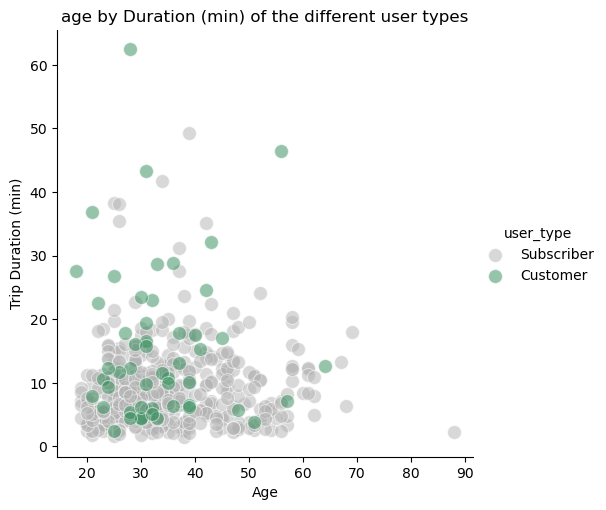

In [731]:
# plot matrix: sample 800 user_type
samples = np.random.choice(Bike_clean.shape[0], 500, replace = False)
df_samp = Bike_clean.loc[samples,:]
pal = dict(Customer="seagreen", Subscriber=".7")
g = sb.FacetGrid(df_samp, hue="user_type", palette=pal, height=5)
g.map(sb.scatterplot, "age", "duration_min", s=100, alpha=0.5);
plt.xlabel('Age');
plt.ylabel('Trip Duration (min)');
plt.title("age by Duration (min) of the different user types");
g.add_legend();

> * The age and duration of subscribers are meagerly distributed.
> * The age and duration of subscribers are strongly distributed in the lower left part of the graph: 20-35 years old, 2-15 minutes.

**Age vs Trip Duration/Distance by different Customer types**

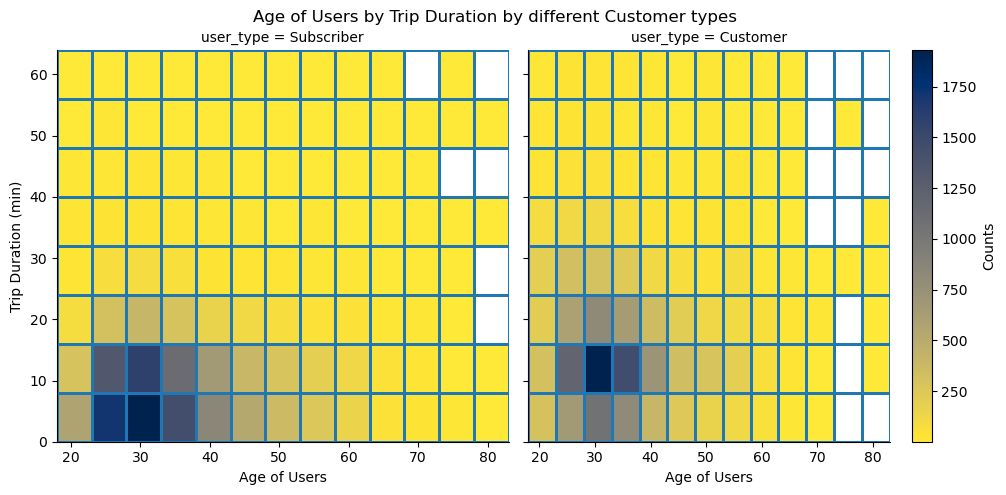

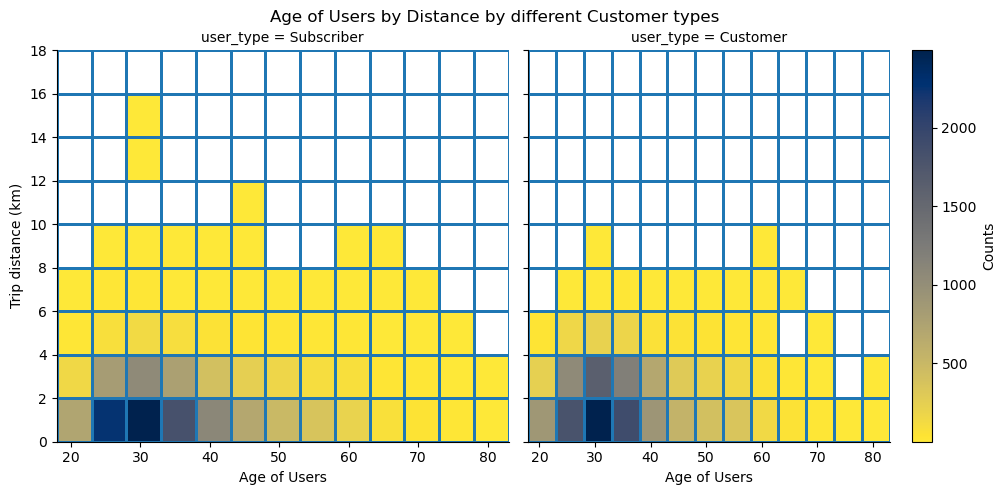

In [725]:
#plot 2D histogram showing counts of duration in min vs Year of birth vs Customer type
xbin = np.arange(Bike_clean["age"].min(), 79+5, 5)
ybin = np.arange(0, 72, 8)
#set grid size
grid = sb.FacetGrid(data = Bike_clean, col = 'user_type',height=5)
grid.map(plt.hist2d, 'age','duration_min',cmin=0.5,cmap = 'cividis_r',bins=[xbin, ybin]);
plt.colorbar().set_label('Counts');

plt.subplots_adjust(top=0.9)
grid.set_ylabels("Trip Duration (min)");
grid.set_xlabels("Age of Users");
grid.fig.suptitle("Age of Users by Trip Duration by different Customer types");


#plot 2D histogram showing counts of distances vs Year of birth vs Customer type
xbin = np.arange(Bike_clean["age"].min(), 79+5, 5)
ybin = np.arange(0, 20, 2)
#set grid size
grid = sb.FacetGrid(data = Bike_clean, col = 'user_type',height=5)
grid.map(plt.hist2d, 'age','trip_km',cmin=0.5,cmap = 'cividis_r',bins=[xbin, ybin]);
plt.colorbar().set_label('Counts');

plt.subplots_adjust(top=0.9)
grid.set_ylabels("Trip distance (km)");
grid.set_xlabels("Age of Users");
grid.fig.suptitle("Age of Users by Distance by different Customer types");

> * Most users are between 25 and 35 years old, are slightly more subscribers than customers, and have a maximum trip duration of 15 min for a maximum distance of 4 km, therefore, we can conclude that the users use the service for a certain purpose for a certain duration and length of time.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> * Subscriber usage time during the week does not change much on average.
> * Subscriber usage on weekends is slightly higher than on weekdays.
> * Customers cycled on average 1.5 times the duration of subscribers. The gender "Other" cycled the longest, which means that either men or women did not specify their gender or that there were outliers in the data.
> * The majority of trips are less than 4 km in length.


### Were there any interesting or surprising interactions between features?

> * Most users are between 25 and 35 years old, are slightly more subscribers than customers, and have a trip duration between 3 and 15 Minutes for a maximum distance of 4 km, therefore, we can conclude that the users use the service for a specific purpose, , which is for a defined duration of time and a distance traveled.

In [728]:
# drop Created Index column
Bike_clean.drop('index', axis = 1, inplace = True)
# Safe cleaned Dataset
Bike_clean.to_csv("Cleaned_Data.csv", sep=',',index=False, encoding='utf-8')

## Conclusions

This dataset contains information about individual trips in a bike share system that covers the greater San Francisco Bay area

**Univariate Exploration:**

1- The dataset contains only trips starting in February.

2- Bicycles are used more frequently during the week than on weekends.

3- Nearly 75 % of the users are male.

5 - There are 9 times more Subscribers than Customers in the dataset.

5 - The most of the trips are between 0.5 and 1.5 km. 

6 - The most common age groups are between 23 and 28 and between 30 and 35 years old.

7- The duration distribution has a long tail. When converted to a logarithmic scale, the plot can correspond to a normal distribution, with a peak between 5-20 minutes.  

8- In the `duration_min` column, there are outliers where a trip takes longer than 67.5 minutes, less than 0.05% of the Users. I therefore drop these outliers. 

9- The distribution of ages has a long tail and is left-skewed. After using a logarithmic transformation, there is a peak between 25 and 35.

10- Peaks occurred around 8 to 9 a.m. and 4 to 6 p.m., which is the same time as commuting time.


**Bivariate Exploration:**

11- The trips take longer on weekends than on weekdays.

12 - There are two peaks in the start time duration heat map, one between 8-10am and the other between 4-6pm. The duration of the two peaks are 5-10 minutes. This indicates that most users use sharing bikes for commute trips that take 5-10 minutes.

13- User type vs. duration: Subscribers on average have a shorter trips, but more outliers.

14- User type vs. sharing: Bike sharing only available for subscribers.

15- User Type vs. Day of Week: On weekdays, user type does not affect goBike's daily traffic. On weekends, the daily frequency of customers barely changes, while that of subscribers decreases sharply.

16- The 24 to 33 year-olds Users are the main group of Users, cycling for the longest duration. They spend mostly 5-10 minutes on the road. And this is the only peak value of the heatmap.

17- There are no large differences between genders regarding the duration of trips and the distance cycled.

18- Customers are more likely to ride longer distances for a longer duration, while subscribers are more likely to ride shorter distances.



**Multivariate Exploration:**

19-Subscriber usage time during the week does not change much on average, while at weekends is slightly higher than on weekdays.


20- Most users are between 25 and 35 years old, are slightly more subscribers than customers, and have a trip duration between 3 and 15 Minutes for a maximum distance of 4 km, therefore, we can conclude that the users use the service for a specific purpose, , which is for a defined duration of time and a distance traveled.




During this project, I had to clean the data and create new feature. I analyzed the data by creating exploratory charts and then using univariate, bivariate, and multivariate charts to further explore relationships and trends in duration and distance traveled by age, gender, and user type. The results did not yield any major surprises, except that male users were in the majority.